In [1]:
%pip install pennylane scikit-learn numpy matplotlib
%pip install qiskit
%pip install qiskit[visualization] 
%pip install qiskit-aer
%pip install qiskit-ibm-runtime
%pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
   ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/536.2 kB ? eta -:--:--
   ------------------- -------------------- 262.1/536.2 kB ? eta -:--:--
   ---------------------------------------- 536.2/536.2 kB 1.1 MB/s  0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136928 sha256=b6c77d1064262c1ea9d3dc8b526df59717892a36c0b50be30a1729a3ab87bcd9
  Stored in directory: c:\users\admi

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.6 MB 1.1 MB/s eta 0:00:09
   --- ------------------------------------ 0.8/9.6 MB 1.1 MB/s eta 0:00:09
   ---- ----------------------------------- 1.0/9.6 MB 1.1 MB/s eta 0:00:09
   ----- ---------------------------------- 1.3/9.6 MB 1.1 MB/s eta 0:00:08
   ----- ---------------------------------- 1.3/9.6 MB 1.1 MB/s eta 0:00:08
   ------ --------------------------------- 1.6/9.6 MB 1.1 MB/s eta 0:00:08
   ------- -------------------------------- 1.8/9.6 MB 1.1 MB/s eta 0:00:08
   -------- ------------------------------- 2.1/9.6 MB 1.1 MB/s eta 0:00:07
   --------- ------------------------------ 2.4/9.6 MB 1.1 MB/s eta 0:00:07
   ---------- --------------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

CSV_PATH = "concrete_cleanLOF.csv"

FEATURE_COLS = [
    "Cement",
    "BlastFurnaceSlag",
    "FlyAsh",
    "Water",
    "Superplasticizer",
    "CoarseAggregate",
    "FineAggregate",
    "Age",
]
TARGET_COL = "ConcreteCompressiveStrength"
OUTLIER_FLAG = "is_outlier"             

df = pd.read_csv(CSV_PATH)

missing = [c for c in FEATURE_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Faltan columnas en el CSV: {missing}")

X = df[FEATURE_COLS].to_numpy(dtype=np.float64)
y_reg = df[TARGET_COL].to_numpy(dtype=np.float64) if TARGET_COL in df.columns else None
y_clf = df[OUTLIER_FLAG].astype(int).to_numpy() if OUTLIER_FLAG in df.columns else None

N_SAMPLES, N_FEATURES = X.shape
print(f"[INFO] Cargadas {N_SAMPLES} filas con {N_FEATURES} features.")

X = StandardScaler().fit_transform(X)
X = MinMaxScaler(feature_range=(-1.0, 1.0)).fit_transform(X)

[INFO] Cargadas 978 filas con 8 features.


C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\3611937236.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\3611937236.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\3611937236.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


=== Benchmark Embeddings MANUALES (PennyLane) ===
           Qubits  Total (s)  ms / muestra  µs / feature
Embedding                                               
Amplitude       3      5.778         5.908       738.457
Angle           8      2.035         2.081       260.089
Basis           8      1.099         1.124       140.501


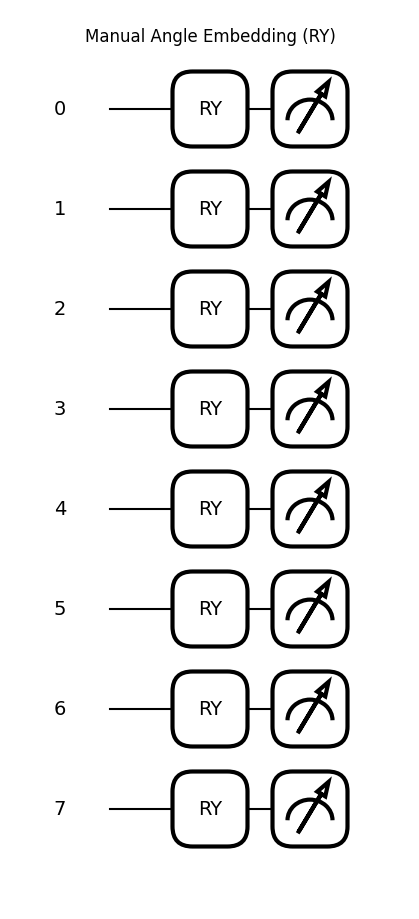

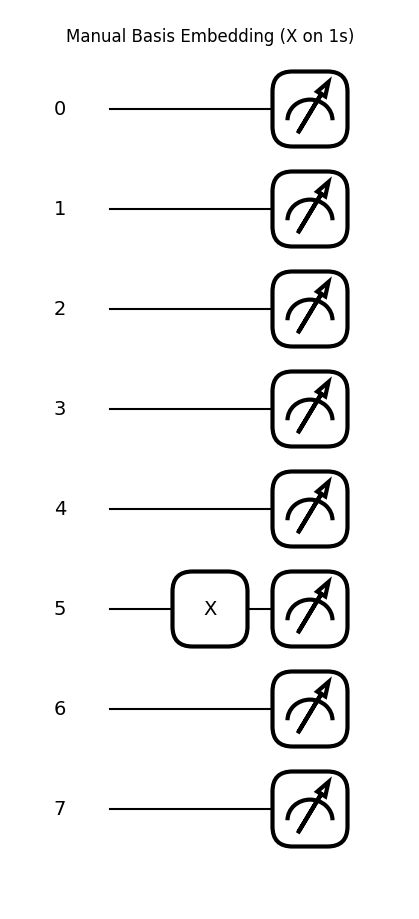

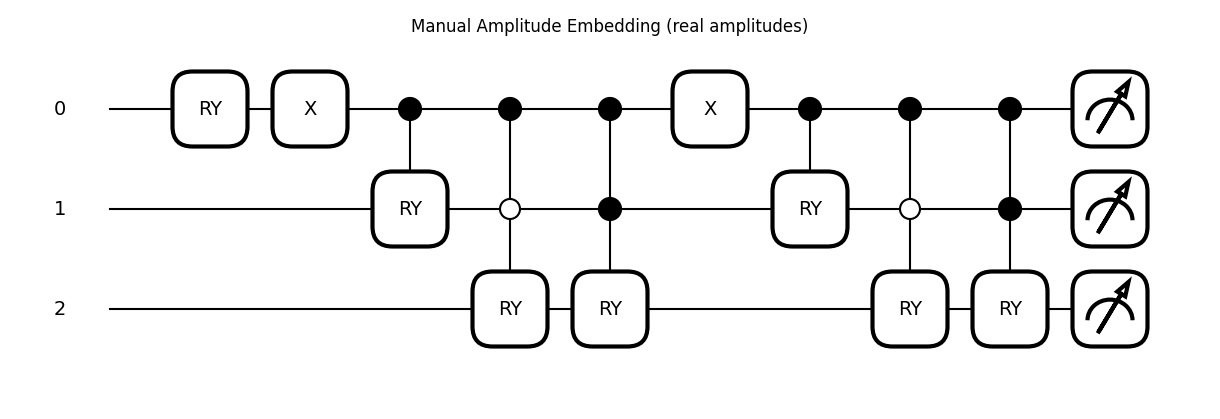

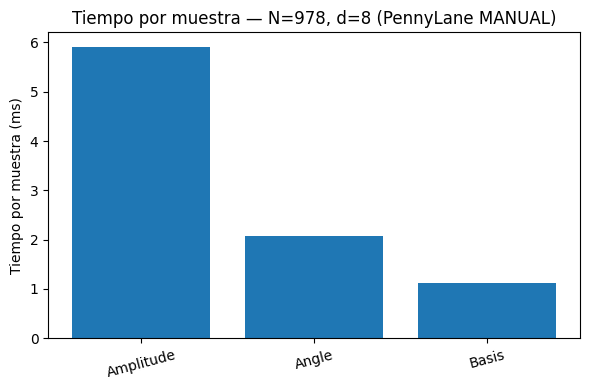

[Angle] Estado global: tamaño = 256 | norma^2 = 1.0000000000000002
[Basis] Probabilities: argmax = 4 prob_max = 1.0
[Amplitude] Estado global: tamaño = 8 | norma^2 = 1.0


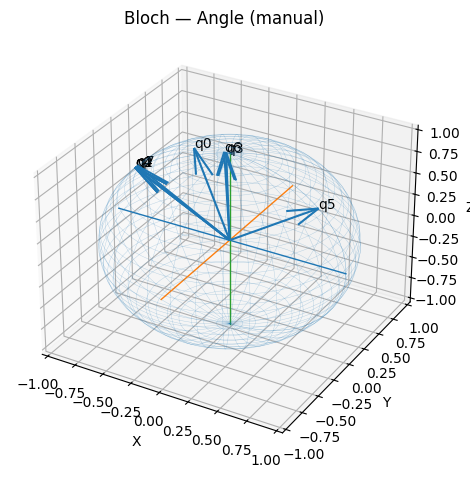

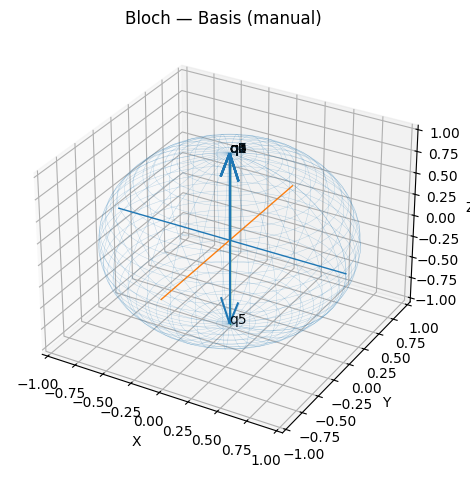

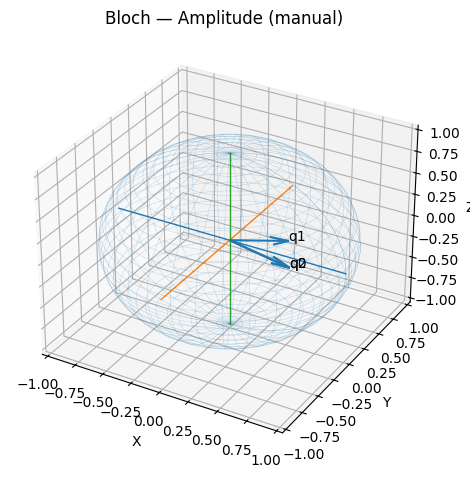

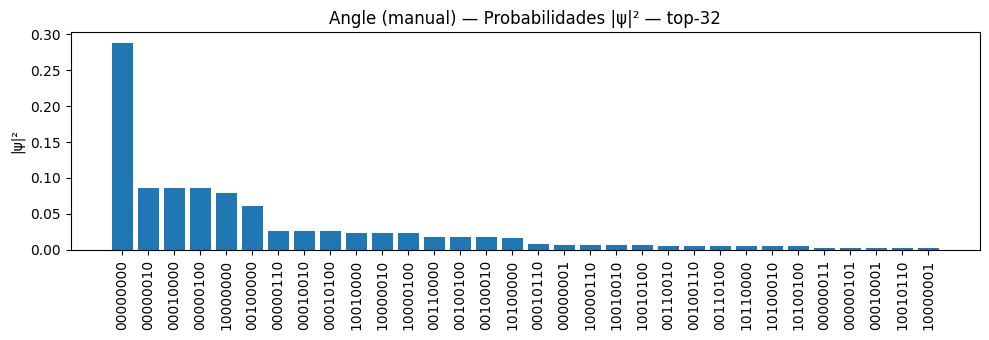

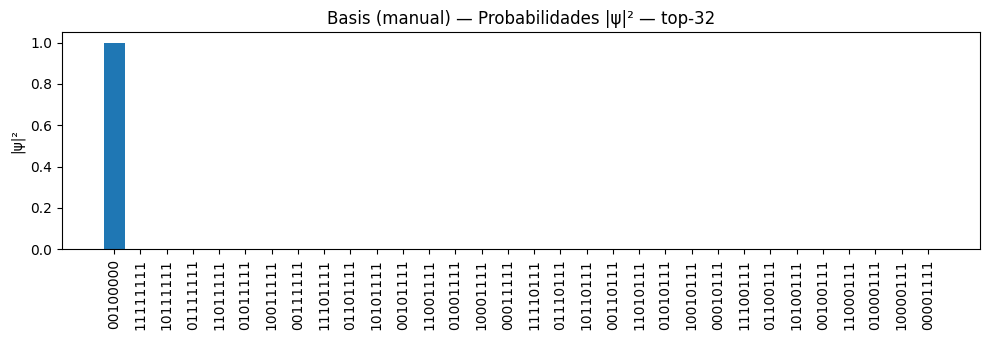

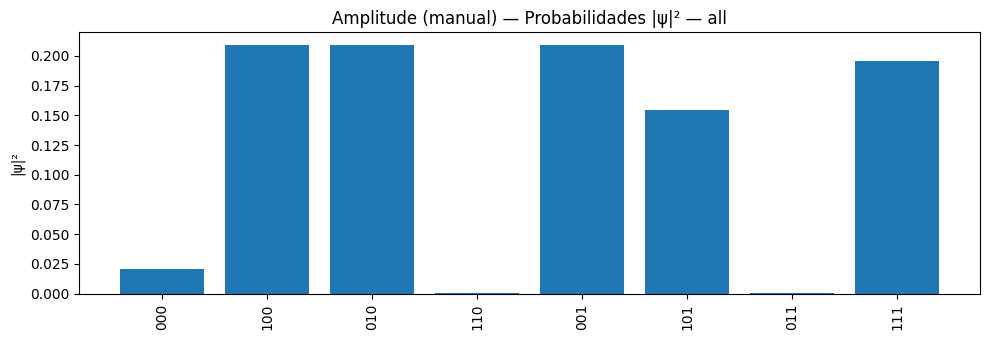

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import time
import pandas as pd

assert 'X' in globals(), "Primero corre la celda de carga/preprocesamiento del dataset (X, y, etc.)"
N, d = X.shape

def binarize_sign(x: np.ndarray) -> np.ndarray:
    return (x > 0).astype(int)

def _normalize_pad_pow2(v):
    v = np.array(v, dtype=float).ravel()
    n = int(np.ceil(np.log2(max(1, len(v)))))
    size = 2**n
    if len(v) < size:
        v = np.pad(v, (0, size - len(v)))
    norm = np.linalg.norm(v)
    if norm == 0:
        v = np.zeros_like(v)
        v[0] = 1.0
    else:
        v = v / norm
    return v

def angle_embed_manual(x, wires, rotation='Y'):
    rot = rotation.upper()
    gate = {'X': qml.RX, 'Y': qml.RY, 'Z': qml.RZ}.get(rot, None)
    if gate is None:
        raise ValueError("rotation debe ser 'X', 'Y' o 'Z'.")
    for wi, xi in zip(wires, x):
        gate(float(xi), wires=wi)

def basis_embed_manual(bits, wires):
    if len(bits) != len(wires):
        raise ValueError("bits y wires deben tener la misma longitud")
    for wi, bi in zip(wires, bits):
        if int(bi) == 1:
            qml.PauliX(wires=wi)

def _load_amplitudes_real_probs_only(v, wires):
    n = len(wires)
    if n == 0:
        return
    if len(v) != 2**n:
        raise ValueError("Longitud de v debe ser 2**len(wires)")
    if n == 1:
        alpha, beta = float(abs(v[0])), float(abs(v[1]))
        theta = 2*np.arctan2(beta, max(alpha, 1e-12))
        qml.RY(theta, wires=wires[0])
        return
    half = 2**(n-1)
    a, b = np.abs(v[:half]), np.abs(v[half:])
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    theta = 2*np.arctan2(nb, max(na, 1e-12))
    msq = wires[0]
    qml.RY(theta, wires=msq)
    tail = wires[1:]

    if na > 1e-12:
        def sub_a():
            _load_amplitudes_real_probs_only(a/na, tail)
        qml.ctrl(sub_a, control=msq, control_values=[0])()
    if nb > 1e-12:
        def sub_b():
            _load_amplitudes_real_probs_only(b/nb, tail)
        qml.ctrl(sub_b, control=msq, control_values=[1])()

def amplitude_embed_manual_from_features(x, wires):
    v = _normalize_pad_pow2(x)
    if len(v) != 2**len(wires):
        raise ValueError("Número de wires insuficiente para vector de amplitudes.")
    _load_amplitudes_real_probs_only(v, wires)

qubits_angle = d
wires_angle = list(range(qubits_angle))
dev_angle = qml.device("default.qubit", wires=wires_angle, shots=None)

qubits_basis = d
wires_basis = list(range(qubits_basis))
dev_basis = qml.device("default.qubit", wires=wires_basis, shots=None)

qubits_amp = int(np.ceil(np.log2(d)))
wires_amp = list(range(qubits_amp))
dev_amp = qml.device("default.qubit", wires=wires_amp, shots=None)

@qml.qnode(dev_angle, diff_method=None)
def manual_angle_qnode(x):
    angle_embed_manual(x, wires=wires_angle, rotation='Y')
    return qml.state()

@qml.qnode(dev_basis, diff_method=None)
def manual_basis_qnode(x):
    bits = binarize_sign(x)[:len(wires_basis)]
    basis_embed_manual(bits, wires=wires_basis)
    return qml.probs(wires=wires_basis)

@qml.qnode(dev_amp, diff_method=None)
def manual_amplitude_qnode(x):
    amplitude_embed_manual_from_features(x, wires=wires_amp)
    return qml.state()

x0 = X[0]
fig, ax = qml.draw_mpl(manual_angle_qnode)(x0)
fig.suptitle("Manual Angle Embedding (RY)")
fig.tight_layout()

fig, ax = qml.draw_mpl(manual_basis_qnode)(x0)
fig.suptitle("Manual Basis Embedding (X on 1s)")
fig.tight_layout()

fig, ax = qml.draw_mpl(manual_amplitude_qnode)(x0)
fig.suptitle("Manual Amplitude Embedding (real amplitudes)")
fig.tight_layout()

def _state_to_probs(psi):
    p = np.abs(psi)**2
    s = p.sum()
    return p if s == 0 else p/s

def benchmark_embedding(name, fn, returns_state=True, keep_examples_idx=(0,1,2)):
    _ = fn(X[0]) 
    t0 = time.perf_counter()
    examples = []
    for i, x in enumerate(X):
        out = fn(x)
        if i in keep_examples_idx:
            if returns_state:
                p = _state_to_probs(out)
                idx = int(np.argmax(p))
                examples.append({
                    "index": i, "kind": "state",
                    "argmax_idx": idx, "argmax_prob": float(p[idx]),
                    "dim": len(out)
                })
            else:
                idx = int(np.argmax(out))
                examples.append({
                    "index": i, "kind": "probs",
                    "argmax_idx": idx, "argmax_prob": float(out[idx]),
                    "dim": len(out)
                })
    total_s = time.perf_counter() - t0
    return total_s, examples

angle_total_s, angle_examples = benchmark_embedding("Angle", manual_angle_qnode, returns_state=True)
basis_total_s, basis_examples = benchmark_embedding("Basis", manual_basis_qnode, returns_state=False)
amp_total_s,   amp_examples   = benchmark_embedding("Amplitude", manual_amplitude_qnode, returns_state=True)

rows = []
info_qubits = {
    "Angle": qubits_angle,
    "Basis": qubits_basis,
    "Amplitude": qubits_amp
}
for name, total_s in [
    ("Angle", angle_total_s),
    ("Basis", basis_total_s),
    ("Amplitude", amp_total_s),
]:
    per_sample = total_s / N
    per_feature = per_sample / d
    rows.append({
        "Embedding": name,
        "Qubits": info_qubits[name],
        "Total (s)": total_s,
        "ms / muestra": per_sample * 1e3,
        "µs / feature": per_feature * 1e6
    })

df_bench_manual = pd.DataFrame(rows).set_index("Embedding").sort_values("ms / muestra", ascending=False)
print("=== Benchmark Embeddings MANUALES (PennyLane) ===")
print(df_bench_manual.round(3))

plt.figure(figsize=(6,4))
plt.bar(df_bench_manual.index.tolist(), df_bench_manual["ms / muestra"].values)
plt.ylabel("Tiempo por muestra (ms)")
plt.title(f"Tiempo por muestra — N={N}, d={d} (PennyLane MANUAL)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

SIGMA_X = np.array([[0,1],[1,0]], dtype=complex)
SIGMA_Y = np.array([[0,-1j],[1j,0]], dtype=complex)
SIGMA_Z = np.array([[1,0],[0,-1]], dtype=complex)

def bloch_from_dm(rho_1q: np.ndarray):
    rx = np.real(np.trace(rho_1q @ SIGMA_X))
    ry = np.real(np.trace(rho_1q @ SIGMA_Y))
    rz = np.real(np.trace(rho_1q @ SIGMA_Z))
    return np.array([rx, ry, rz])

def plot_bloch_vectors(vectors, title="Bloch vectors"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2*np.pi, 64)
    v = np.linspace(0, np.pi, 32)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, linewidth=0.3, alpha=0.3)

    lim = 1.05
    ax.plot([-1,1],[0,0],[0,0], linewidth=1)
    ax.plot([0,0],[-1,1],[0,0], linewidth=1)
    ax.plot([0,0],[0,0],[-1,1], linewidth=1)

    for i, r in enumerate(vectors):
        ax.quiver(0,0,0, r[0], r[1], r[2], length=1, normalize=False)
        ax.text(r[0], r[1], r[2], f"q{i}")
    ax.set_xlim([-lim, lim]); ax.set_ylim([-lim, lim]); ax.set_zlim([-lim, lim])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

@qml.qnode(dev_angle, diff_method=None)
def dm_angle(x):
    angle_embed_manual(x, wires=wires_angle, rotation='Y')
    return [qml.density_matrix(wires=[wi]) for wi in wires_angle]

@qml.qnode(dev_basis, diff_method=None)
def dm_basis(x):
    bits = binarize_sign(x)[:len(wires_basis)]
    basis_embed_manual(bits, wires=wires_basis)
    return [qml.density_matrix(wires=[wi]) for wi in wires_basis]

@qml.qnode(dev_amp, diff_method=None)
def dm_amp(x):
    amplitude_embed_manual_from_features(x, wires=wires_amp)
    return [qml.density_matrix(wires=[wi]) for wi in wires_amp]

@qml.qnode(dev_angle, diff_method=None)
def state_angle(x):
    angle_embed_manual(x, wires=wires_angle, rotation='Y')
    return qml.state()

@qml.qnode(dev_basis, diff_method=None)
def probs_basis(x):
    bits = binarize_sign(x)[:len(wires_basis)]
    basis_embed_manual(bits, wires=wires_basis)
    return qml.probs(wires=wires_basis)

@qml.qnode(dev_amp, diff_method=None)
def state_amp(x):
    amplitude_embed_manual_from_features(x, wires=wires_amp)
    return qml.state()

x0 = X[0]

rho_list = dm_angle(x0)
bloch_angle = [bloch_from_dm(r) for r in rho_list]
plot_bloch_vectors(bloch_angle, title="Bloch — Angle (manual)")
psi_angle = state_angle(x0)
print("[Angle] Estado global: tamaño =", len(psi_angle), "| norma^2 =", float(np.sum(np.abs(psi_angle)**2)))

rho_list = dm_basis(x0)
bloch_basis = [bloch_from_dm(r) for r in rho_list]
plot_bloch_vectors(bloch_basis, title="Bloch — Basis (manual)")
p_basis = probs_basis(x0)
print("[Basis] Probabilities: argmax =", int(np.argmax(p_basis)), "prob_max =", float(np.max(p_basis)))

rho_list = dm_amp(x0)
bloch_amp = [bloch_from_dm(r) for r in rho_list]
plot_bloch_vectors(bloch_amp, title="Bloch — Amplitude (manual)")
psi_amp = state_amp(x0)
print("[Amplitude] Estado global: tamaño =", len(psi_amp), "| norma^2 =", float(np.sum(np.abs(psi_amp)**2)))

def _bitstring(i: int, n_qubits: int, little_endian=True) -> str:
    s = format(i, f"0{n_qubits}b")
    return s[::-1] if little_endian else s

def _plot_spectrum(values, n_qubits, title, ylabel, top_k=None, little_endian=True):
    vals = np.asarray(values)
    idx = np.arange(len(vals))

    if top_k is not None and top_k < len(vals):
        idx = np.argsort(vals)[-top_k:][::-1]

    labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]

    plt.figure(figsize=(10, 3.5))
    plt.bar(np.arange(len(idx)), vals[idx])
    plt.xticks(np.arange(len(idx)), labels, rotation=90)
    plt.ylabel(ylabel)
    plt.title(f"{title} — {'top-'+str(len(idx)) if len(idx)<len(values) else 'all'}")
    plt.tight_layout()
    plt.show()

def plot_state_amplitudes_pl(psi, n_qubits, title, show_phase=False, top_k=None, little_endian=True):
    amp = np.abs(psi)
    probs = amp**2
    _plot_spectrum(probs, n_qubits, title + " — Probabilidades |ψ|²", ylabel="|ψ|²", top_k=top_k, little_endian=little_endian)

    if show_phase:
        phase = np.angle(psi)
        if top_k is not None and top_k < len(amp):
            idx = np.argsort(amp)[-top_k:][::-1]
        else:
            idx = np.arange(len(amp))
        labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]
        plt.figure(figsize=(10, 3.0))
        plt.stem(np.arange(len(idx)), phase[idx], use_line_collection=True)
        plt.xticks(np.arange(len(idx)), labels, rotation=90)
        plt.ylabel("fase(ψ) [rad]")
        plt.title(title + " — Fase(ψ)")
        plt.tight_layout()
        plt.show()

def plot_probs_pl(probs, n_qubits, title, top_k=None, little_endian=True):
    _plot_spectrum(probs, n_qubits, title + " — Probabilidades |ψ|²", ylabel="|ψ|²", top_k=top_k, little_endian=little_endian)

x0 = X[0]

psi_a = manual_angle_qnode(x0)
plot_state_amplitudes_pl(psi_a, qubits_angle, "Angle (manual)", show_phase=False, top_k=32)

probs_b = manual_basis_qnode(x0)
plot_probs_pl(probs_b, qubits_basis, "Basis (manual)", top_k=32)

psi_amp = manual_amplitude_qnode(x0)
plot_state_amplitudes_pl(psi_amp, qubits_amp, "Amplitude (manual)", show_phase=False, top_k=32)


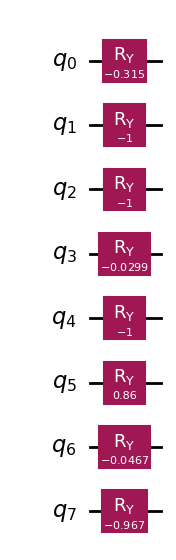

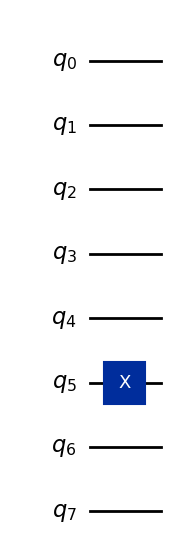

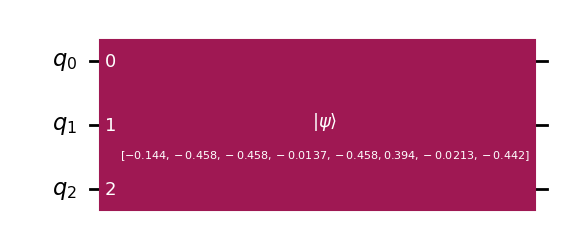

=== Benchmark Embeddings MANUALES (Qiskit) ===
           Qubits  Total (s)  ms / muestra  µs / feature
Embedding                                               
Amplitude       3      1.214         1.241       155.121
Angle           8      0.607         0.621        77.612
Basis           8      0.281         0.288        35.945


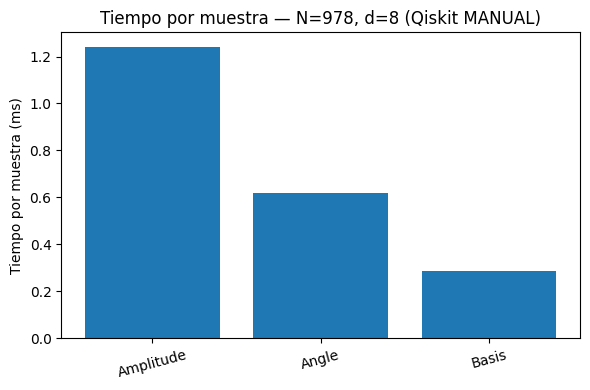

[Angle/Qiskit] Estado global: tamaño = 256 | norma^2 = 1.0000000000000002
[Basis/Qiskit] Probabilities: argmax = 32 prob_max = 1.0
[Amplitude/Qiskit] Estado global: tamaño = 8 | norma^2 = 1.0


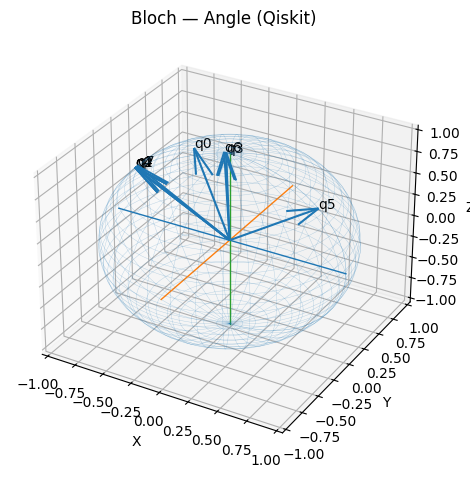

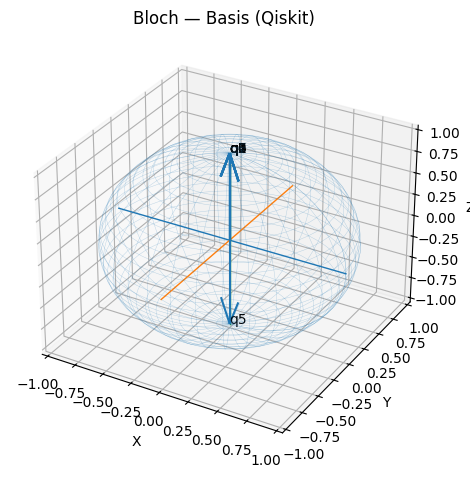

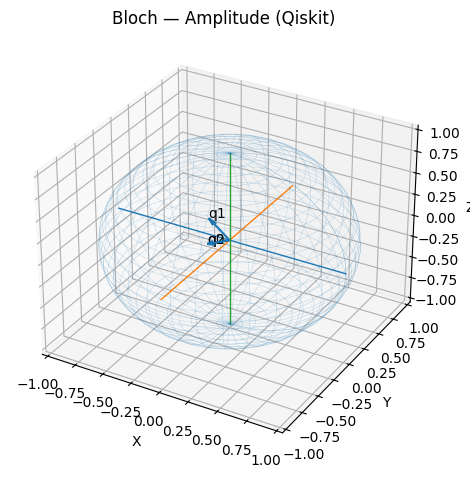

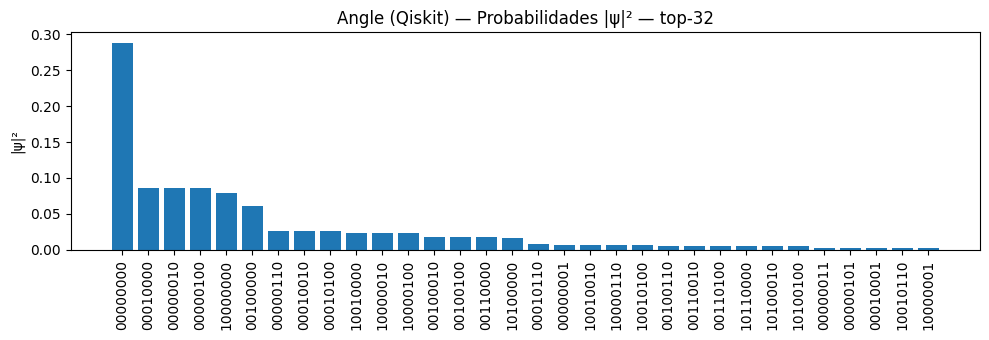

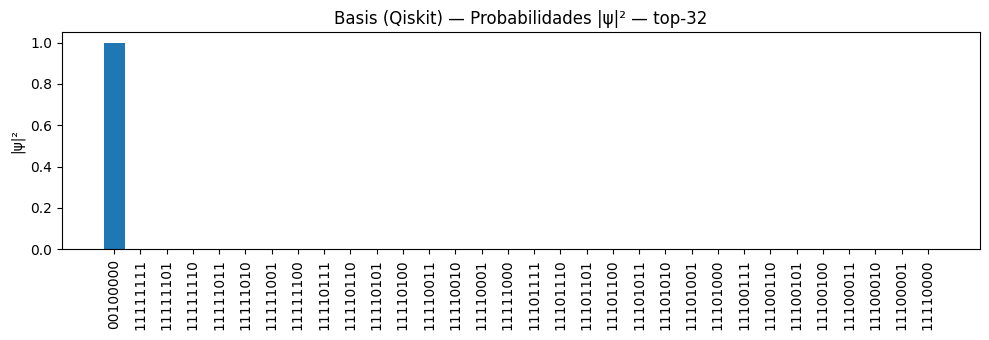

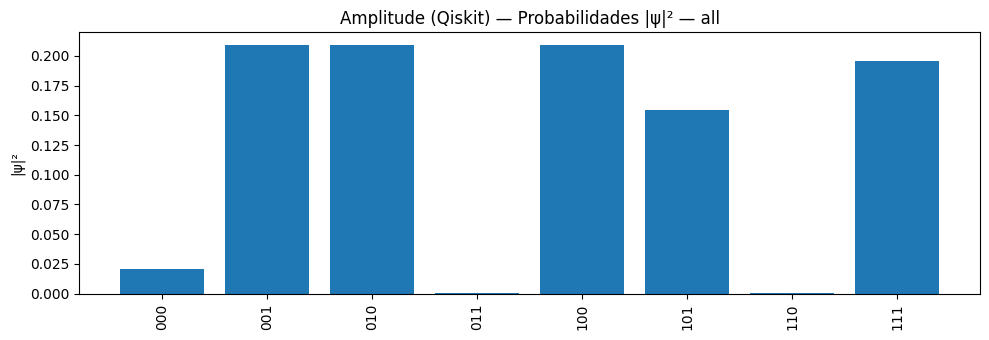

In [18]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.quantum_info.operators import Pauli
from qiskit.visualization import circuit_drawer
from IPython.display import Image, display

assert 'X' in globals(), "Primero corre la celda de carga/preprocesamiento del dataset (X)."
N, d = X.shape

def _normalize_pad_pow2(v):
    v = np.array(v, dtype=float).ravel()
    n = int(np.ceil(np.log2(max(1, len(v)))))
    size = 2**n
    if len(v) < size:
        v = np.pad(v, (0, size - len(v)))
    norm = np.linalg.norm(v)
    if norm == 0:
        v = np.zeros_like(v); v[0] = 1.0
    else:
        v = v / norm
    return v

def qc_angle_manual(x):
    qc = QuantumCircuit(d)
    for i, xi in enumerate(x):
        qc.ry(float(xi), i)
    return qc

def qc_basis_manual(x):
    qc = QuantumCircuit(d)
    bits = (x > 0).astype(int)
    for i, bi in enumerate(bits):
        if int(bi) == 1:
            qc.x(i)
    return qc

def qc_amplitude_manual(x):
    n = int(np.ceil(np.log2(d)))
    qc = QuantumCircuit(n)
    v = _normalize_pad_pow2(x)
    psi = v.astype(complex)
    qc.initialize(psi, list(range(n)))
    return qc

def statevector_of(qc):
    return Statevector.from_instruction(qc)  

def probs_from_statevector(sv):
    p = np.abs(sv.data)**2
    s = p.sum()
    return p if s == 0 else p/s

PAULI_X = Pauli('X').to_matrix()
PAULI_Y = Pauli('Y').to_matrix()
PAULI_Z = Pauli('Z').to_matrix()
def bloch_from_dm(dm_1q: DensityMatrix):
    rho = dm_1q.data
    rx = np.real(np.trace(rho @ PAULI_X))
    ry = np.real(np.trace(rho @ PAULI_Y))
    rz = np.real(np.trace(rho @ PAULI_Z))
    return np.array([rx, ry, rz])

def plot_bloch_vectors(vectors, title="Bloch vectors (Qiskit)"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2*np.pi, 64)
    v = np.linspace(0, np.pi, 32)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, linewidth=0.3, alpha=0.3)
    lim = 1.05
    ax.plot([-1,1],[0,0],[0,0], linewidth=1)
    ax.plot([0,0],[-1,1],[0,0], linewidth=1)
    ax.plot([0,0],[0,0],[-1,1], linewidth=1)
    for i, r in enumerate(vectors):
        ax.quiver(0,0,0, r[0], r[1], r[2], length=1, normalize=False)
        ax.text(r[0], r[1], r[2], f"q{i}")
    ax.set_xlim([-lim, lim]); ax.set_ylim([-lim, lim]); ax.set_zlim([-lim, lim])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

x0 = X[0]
qc_a = qc_angle_manual(x0)
qc_b = qc_basis_manual(x0)
qc_amp = qc_amplitude_manual(x0)

display(circuit_drawer(qc_a, output="mpl")); 
display(circuit_drawer(qc_b, output="mpl")); 
display(circuit_drawer(qc_amp, output="mpl"))

def benchmark_qiskit(build_fn, n_qubits, returns_state=True, keep_examples_idx=(0,1,2)):
    t0 = time.perf_counter()
    examples = []
    for i, x in enumerate(X):
        qc = build_fn(x)
        sv = statevector_of(qc)
        if i in keep_examples_idx:
            p = probs_from_statevector(sv)
            idx = int(np.argmax(p))
            examples.append({
                "index": i,
                "argmax_idx": idx,
                "argmax_prob": float(p[idx]),
                "dim": len(sv.data)
            })
    total_s = time.perf_counter() - t0
    return total_s, examples

angle_total_s, ex_a = benchmark_qiskit(qc_angle_manual, n_qubits=d)
basis_total_s, ex_b = benchmark_qiskit(qc_basis_manual, n_qubits=d)
amp_total_s,   ex_amp = benchmark_qiskit(qc_amplitude_manual, n_qubits=int(np.ceil(np.log2(d))))

rows = []
rows.append({"Embedding":"Angle","Qubits":d,"Total (s)":angle_total_s,"ms / muestra":angle_total_s/N*1e3,"µs / feature":(angle_total_s/N/d)*1e6})
rows.append({"Embedding":"Basis","Qubits":d,"Total (s)":basis_total_s,"ms / muestra":basis_total_s/N*1e3,"µs / feature":(basis_total_s/N/d)*1e6})
rows.append({"Embedding":"Amplitude","Qubits":int(np.ceil(np.log2(d))),"Total (s)":amp_total_s,"ms / muestra":amp_total_s/N*1e3,"µs / feature":(amp_total_s/N/d)*1e6})

df_bench_qiskit = pd.DataFrame(rows).set_index("Embedding").sort_values("ms / muestra", ascending=False)
print("=== Benchmark Embeddings MANUALES (Qiskit) ===")
print(df_bench_qiskit.round(3))

plt.figure(figsize=(6,4))
plt.bar(df_bench_qiskit.index.tolist(), df_bench_qiskit["ms / muestra"].values)
plt.ylabel("Tiempo por muestra (ms)")
plt.title(f"Tiempo por muestra — N={N}, d={d} (Qiskit MANUAL)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

def dm_reducidas_por_qubit(sv: Statevector, n_qubits: int):
    dms = []
    for i in range(n_qubits):
        keep = [i]
        traced = partial_trace(sv, [j for j in range(n_qubits) if j != i])
        dms.append(traced)
    return dms

sv_a = statevector_of(qc_angle_manual(x0))
dms = dm_reducidas_por_qubit(sv_a, d)
bloch_a = [bloch_from_dm(dm1) for dm1 in dms]
plot_bloch_vectors(bloch_a, title="Bloch — Angle (Qiskit)")
print("[Angle/Qiskit] Estado global: tamaño =", len(sv_a.data), "| norma^2 =", float(np.sum(np.abs(sv_a.data)**2)))

sv_b = statevector_of(qc_basis_manual(x0))
dms = dm_reducidas_por_qubit(sv_b, d)
bloch_b = [bloch_from_dm(dm1) for dm1 in dms]
plot_bloch_vectors(bloch_b, title="Bloch — Basis (Qiskit)")
p_b = probs_from_statevector(sv_b)
print("[Basis/Qiskit] Probabilities: argmax =", int(np.argmax(p_b)), "prob_max =", float(np.max(p_b)))

n_amp = int(np.ceil(np.log2(d)))
sv_amp = statevector_of(qc_amplitude_manual(x0))
dms = dm_reducidas_por_qubit(sv_amp, n_amp)
bloch_amp = [bloch_from_dm(dm1) for dm1 in dms]
plot_bloch_vectors(bloch_amp, title="Bloch — Amplitude (Qiskit)")
print("[Amplitude/Qiskit] Estado global: tamaño =", len(sv_amp.data), "| norma^2 =", float(np.sum(np.abs(sv_amp.data)**2)))

def _bitstring(i: int, n_qubits: int, little_endian=False) -> str:
    s = format(i, f"0{n_qubits}b")
    return s[::-1] if little_endian else s

def _plot_spectrum(values, n_qubits, title, ylabel, top_k=None, little_endian=False):
    vals = np.asarray(values)
    idx = np.arange(len(vals))

    if top_k is not None and top_k < len(vals):
        idx = np.argsort(vals)[-top_k:][::-1]

    labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]

    plt.figure(figsize=(10, 3.5))
    plt.bar(np.arange(len(idx)), vals[idx])
    plt.xticks(np.arange(len(idx)), labels, rotation=90)
    plt.ylabel(ylabel)
    plt.title(f"{title} — {'top-'+str(len(idx)) if len(idx)<len(values) else 'all'}")
    plt.tight_layout()
    plt.show()

def plot_state_amplitudes_qk(sv, n_qubits, title, show_phase=False, top_k=None, little_endian=False):
    data = sv.data
    amp = np.abs(data)
    probs = amp**2
    _plot_spectrum(probs, n_qubits, title + " — Probabilidades |ψ|²", ylabel="|ψ|²", top_k=top_k, little_endian=little_endian)

    if show_phase:
        phase = np.angle(data)
        if top_k is not None and top_k < len(amp):
            idx = np.argsort(amp)[-top_k:][::-1]
        else:
            idx = np.arange(len(amp))
        labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]
        plt.figure(figsize=(10, 3.0))
        plt.stem(np.arange(len(idx)), phase[idx], use_line_collection=True)
        plt.xticks(np.arange(len(idx)), labels, rotation=90)
        plt.ylabel("fase(ψ) [rad]")
        plt.title(title + " — Fase(ψ)")
        plt.tight_layout()
        plt.show()

x0 = X[0]

sv_a = Statevector.from_instruction(qc_angle_manual(x0))
plot_state_amplitudes_qk(sv_a, d, "Angle (Qiskit)", show_phase=False, top_k=32, little_endian=False)

sv_b = Statevector.from_instruction(qc_basis_manual(x0))
plot_state_amplitudes_qk(sv_b, d, "Basis (Qiskit)", show_phase=False, top_k=32, little_endian=False)

n_amp = int(np.ceil(np.log2(d)))
sv_amp = Statevector.from_instruction(qc_amplitude_manual(x0))
plot_state_amplitudes_qk(sv_amp, n_amp, "Amplitude (Qiskit)", show_phase=False, top_k=32, little_endian=False)


C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\538541638.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig, ax = qml.draw_mpl(fm_fourier_state)(x0); fig.suptitle("Fourier Feature Map (PennyLane)"); fig.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\538541638.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig, ax = qml.draw_mpl(fm_zz_state)(x0); fig.suptitle("ZZ Feature Map (PennyLane)"); fig.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\538541638.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig, ax = qml.draw_mpl(fm_pauli_state)(x0); fig.suptitle("Pauli Feature Map (PennyLane)"); fig.tight_layout()


=== Benchmark Feature Maps (PennyLane) ===
            Qubits  Total (s)  ms / muestra  µs / feature
FeatureMap                                               
Pauli            8     11.990        12.259      1532.406
Fourier          8     10.123        10.351      1293.883
ZZ               8      5.780         5.911       738.813


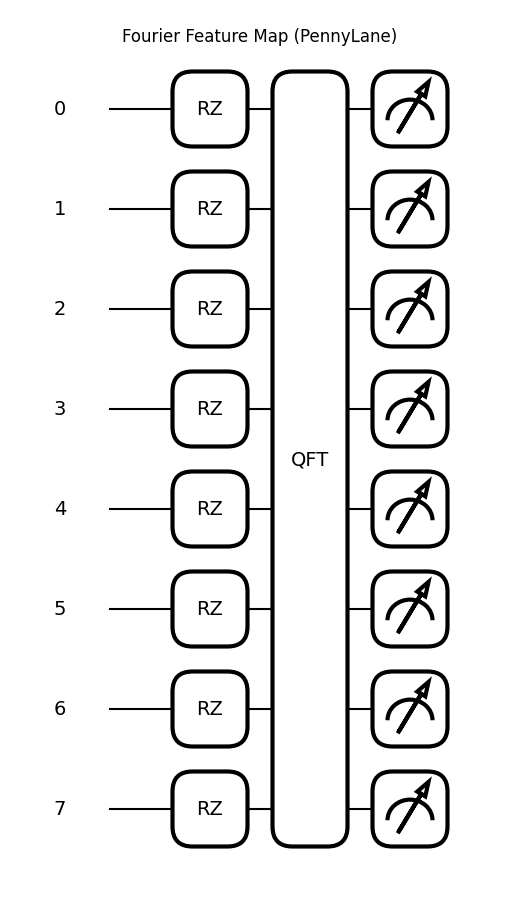

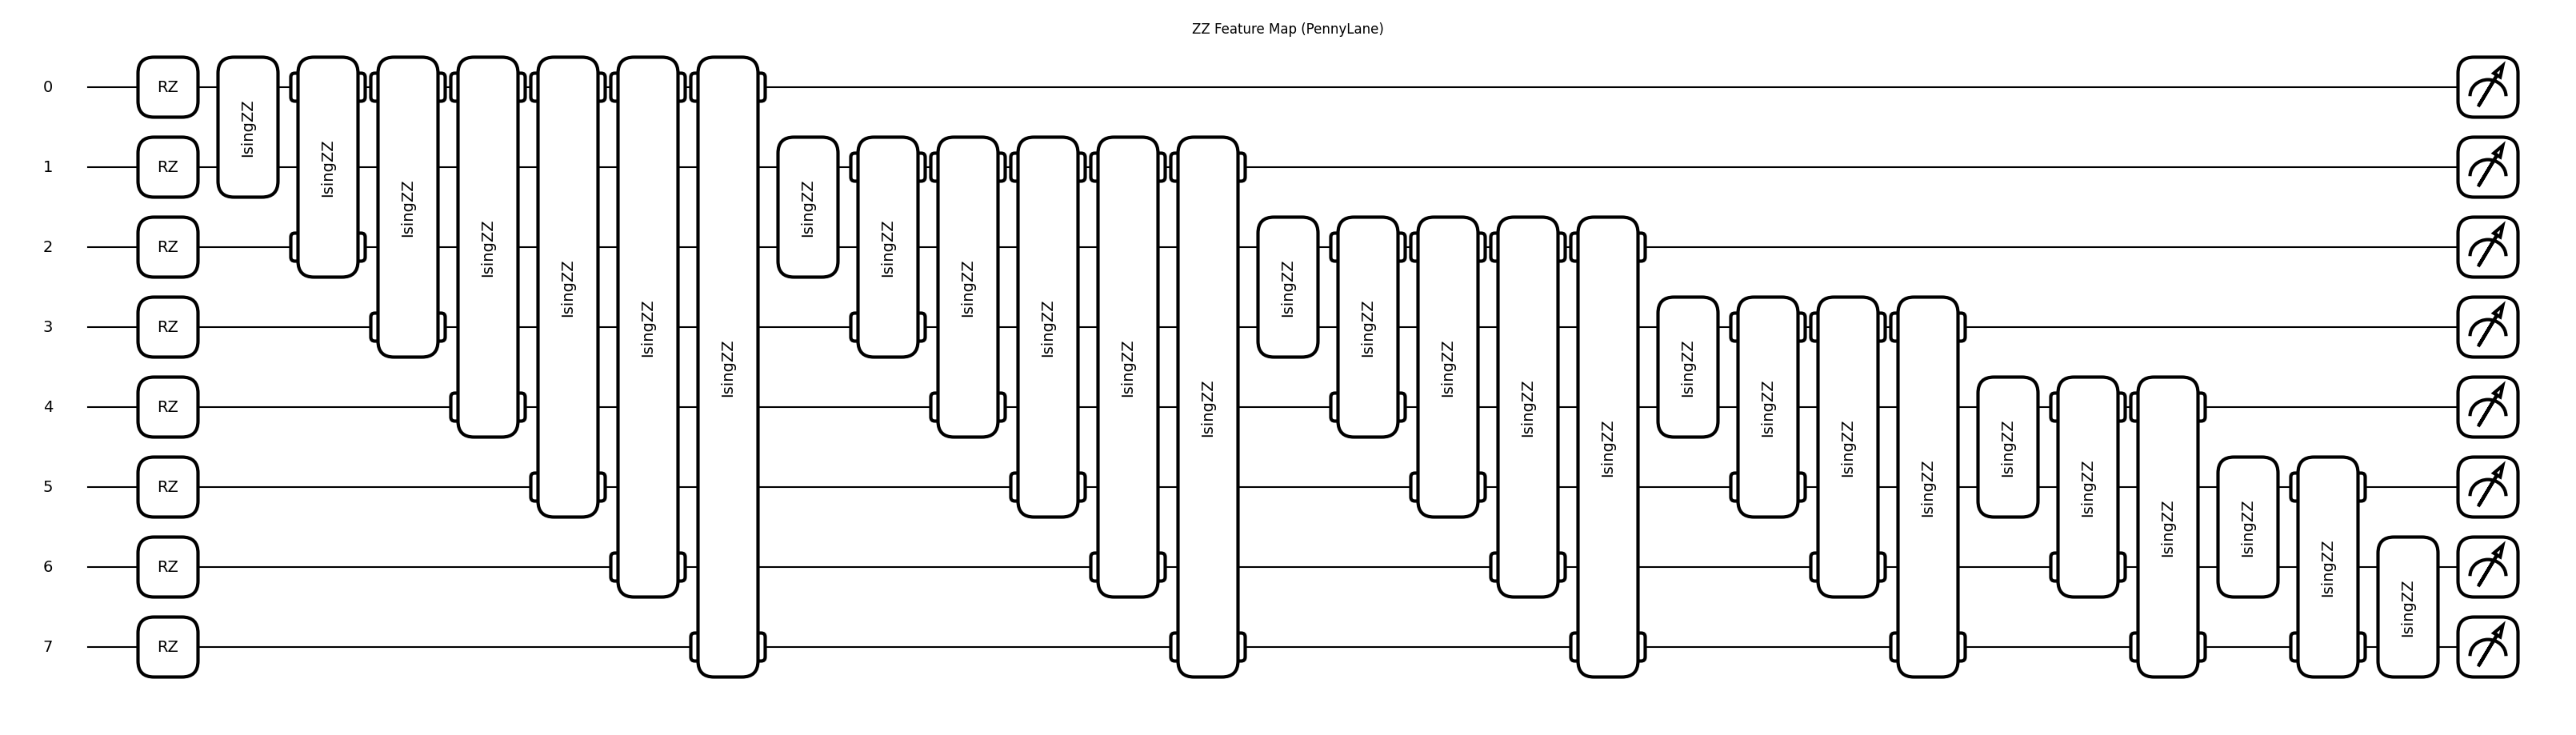

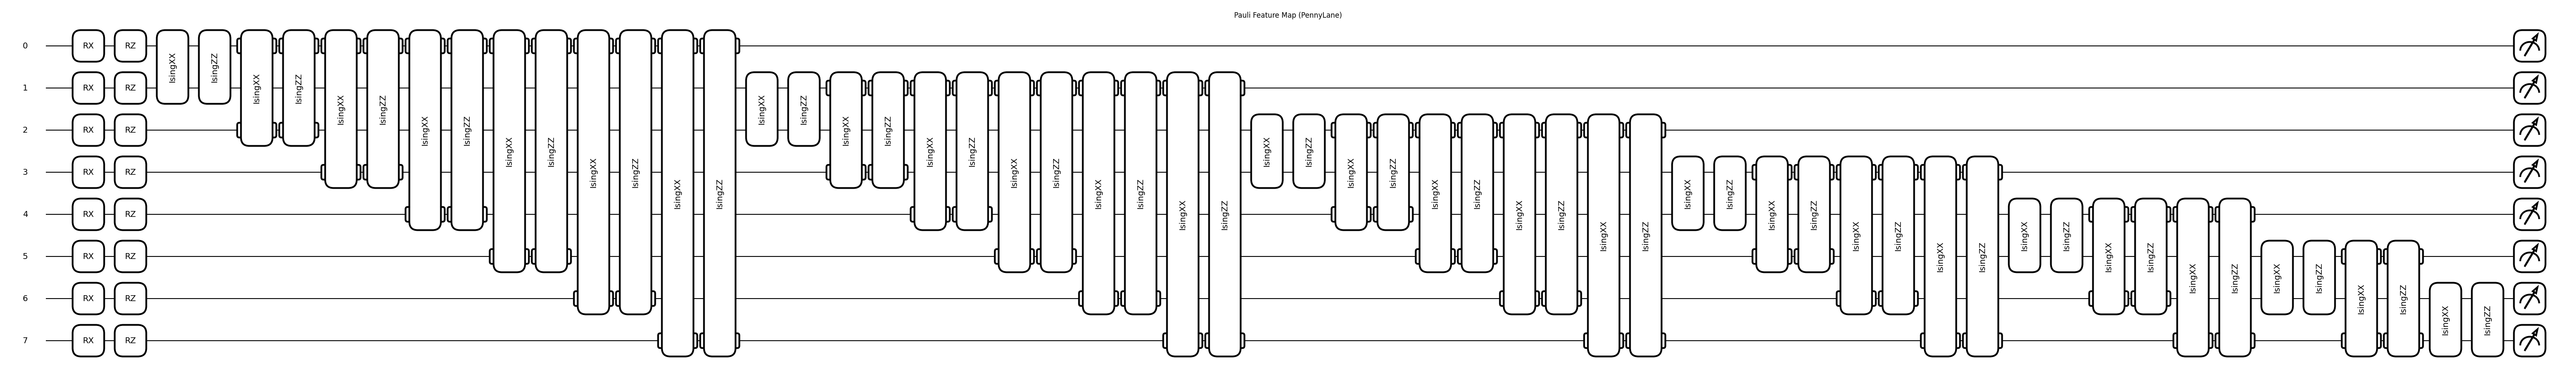

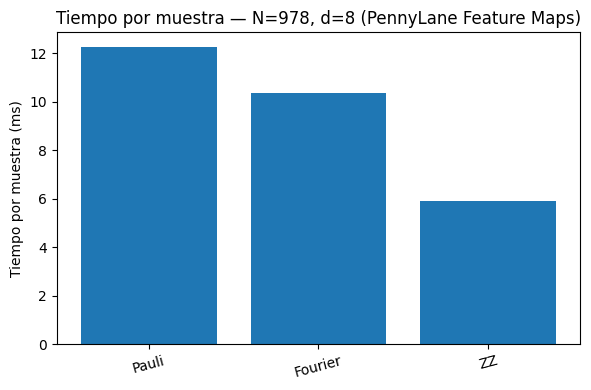

[Fourier/PL] Estado global: tamaño = 256 | norma^2 = 0.9999999999999987
[ZZ/PL] Estado global: tamaño = 256 | norma^2 = 1.0000000000000004
[Pauli/PL] Estado global: tamaño = 256 | norma^2 = 1.0


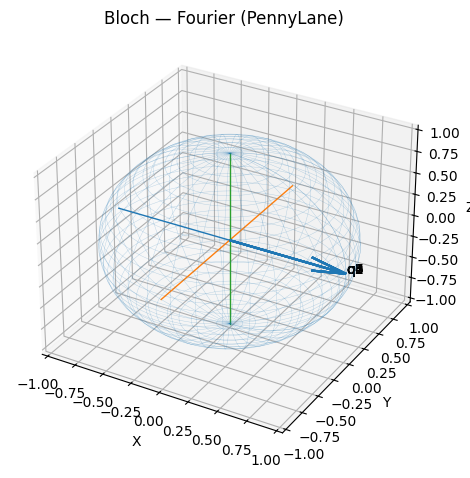

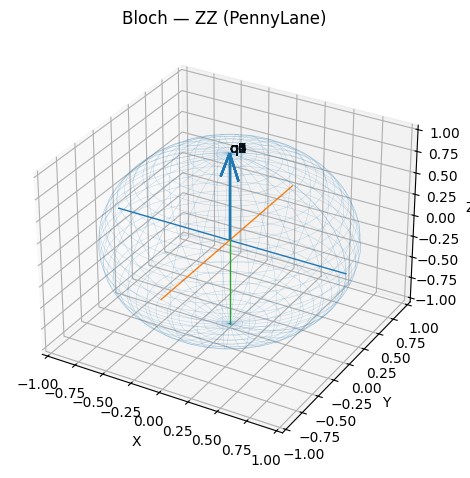

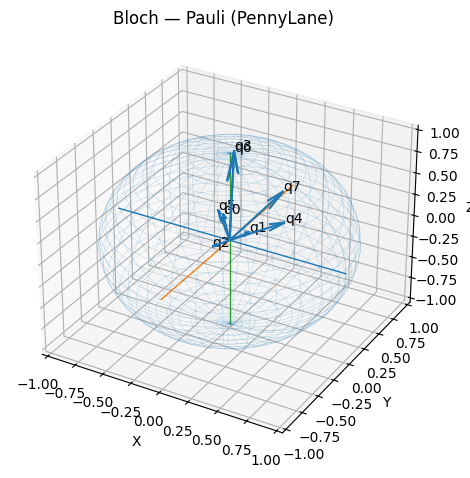

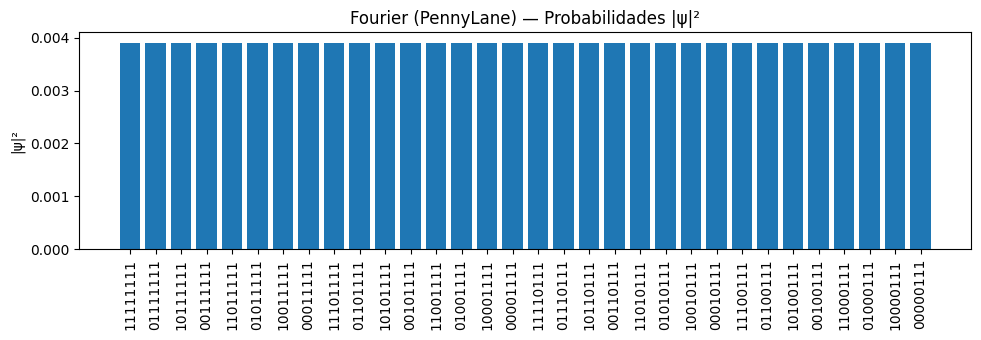

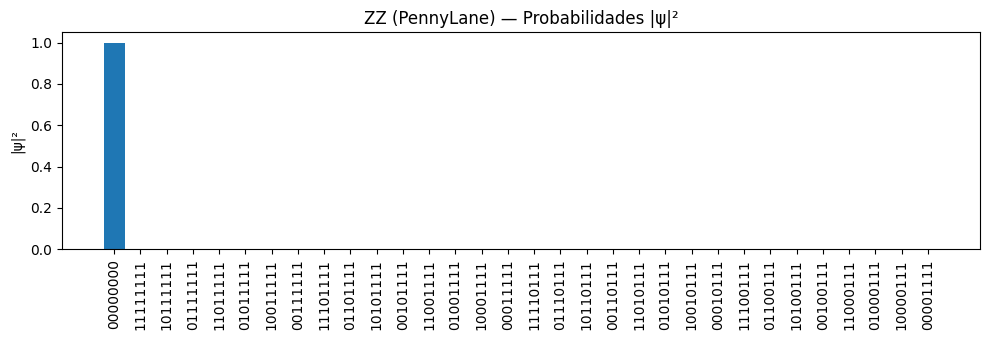

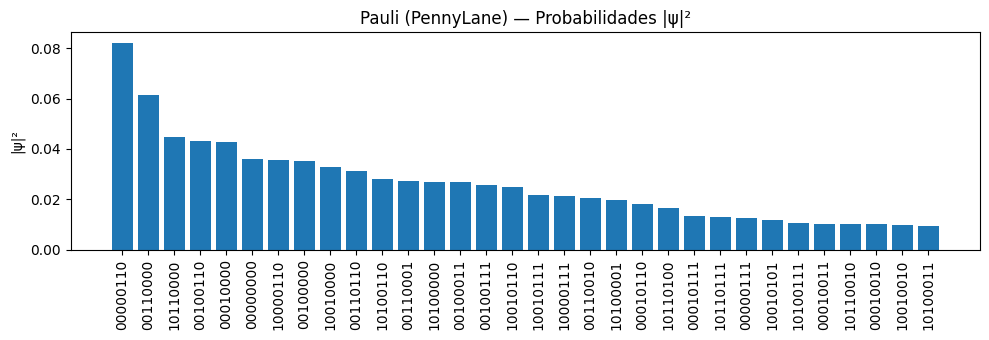

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import time
import pandas as pd

assert 'X' in globals()
N, d = X.shape

def _state_to_probs(psi):
    p = np.abs(psi)**2
    s = p.sum()
    return p if s == 0 else p/s

SIGMA_X = np.array([[0,1],[1,0]], dtype=complex)
SIGMA_Y = np.array([[0,-1j],[1j,0]], dtype=complex)
SIGMA_Z = np.array([[1,0],[0,-1]], dtype=complex)

def bloch_from_dm(rho_1q: np.ndarray):
    rx = np.real(np.trace(rho_1q @ SIGMA_X))
    ry = np.real(np.trace(rho_1q @ SIGMA_Y))
    rz = np.real(np.trace(rho_1q @ SIGMA_Z))
    return np.array([rx, ry, rz])

def plot_bloch_vectors(vectors, title="Bloch"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2*np.pi, 64)
    v = np.linspace(0, np.pi, 32)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, linewidth=0.3, alpha=0.3)
    lim = 1.05
    ax.plot([-1,1],[0,0],[0,0], linewidth=1)
    ax.plot([0,0],[-1,1],[0,0], linewidth=1)
    ax.plot([0,0],[0,0],[-1,1], linewidth=1)
    for i, r in enumerate(vectors):
        ax.quiver(0,0,0, r[0], r[1], r[2], length=1, normalize=False)
        ax.text(r[0], r[1], r[2], f"q{i}")
    ax.set_xlim([-lim, lim]); ax.set_ylim([-lim, lim]); ax.set_zlim([-lim, lim])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

def _bitstring(i: int, n_qubits: int, little_endian=True) -> str:
    s = format(i, f"0{n_qubits}b")
    return s[::-1] if little_endian else s

def _plot_spectrum(values, n_qubits, title, ylabel, top_k=None, little_endian=True):
    vals = np.asarray(values)
    if top_k is not None and top_k < len(vals):
        idx = np.argsort(vals)[-top_k:][::-1]
    else:
        idx = np.arange(len(vals))
    labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]
    plt.figure(figsize=(10, 3.5))
    plt.bar(np.arange(len(idx)), vals[idx])
    plt.xticks(np.arange(len(idx)), labels, rotation=90)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

qubits_fourier = d
wires_fourier = list(range(qubits_fourier))
dev_fourier = qml.device("default.qubit", wires=wires_fourier, shots=None)

def fourier_map(x, wires):
    for i, xi in enumerate(x[:len(wires)]):
        qml.RZ(float(xi), wires=wires[i])
    qml.QFT(wires=wires)

@qml.qnode(dev_fourier, diff_method=None)
def fm_fourier_state(x):
    fourier_map(x, wires_fourier)
    return qml.state()

@qml.qnode(dev_fourier, diff_method=None)
def fm_fourier_dm(x):
    fourier_map(x, wires_fourier)
    return [qml.density_matrix(wires=[wi]) for wi in wires_fourier]

qubits_zz = d
wires_zz = list(range(qubits_zz))
dev_zz = qml.device("default.qubit", wires=wires_zz, shots=None)

def zz_feature_map(x, wires):
    m = len(wires)
    for i, xi in enumerate(x[:m]):
        qml.RZ(float(xi), wires=wires[i])
    for i in range(m):
        for j in range(i+1, m):
            qml.IsingZZ(2.0*float(x[i%len(x)])*float(x[j%len(x)]), wires=[wires[i], wires[j]])

@qml.qnode(dev_zz, diff_method=None)
def fm_zz_state(x):
    zz_feature_map(x, wires_zz)
    return qml.state()

@qml.qnode(dev_zz, diff_method=None)
def fm_zz_dm(x):
    zz_feature_map(x, wires_zz)
    return [qml.density_matrix(wires=[wi]) for wi in wires_zz]

qubits_pauli = d
wires_pauli = list(range(qubits_pauli))
dev_pauli = qml.device("default.qubit", wires=wires_pauli, shots=None)

def pauli_feature_map(x, wires):
    m = len(wires)
    for i, xi in enumerate(x[:m]):
        qml.RX(float(xi), wires=wires[i])
        qml.RZ(float(xi), wires=wires[i])
    for i in range(m):
        for j in range(i+1, m):
            qml.IsingXX(2.0*float(x[i%len(x)])*float(x[j%len(x)]), wires=[wires[i], wires[j]])
            qml.IsingZZ(2.0*float(x[i%len(x)])*float(x[j%len(x)]), wires=[wires[i], wires[j]])

@qml.qnode(dev_pauli, diff_method=None)
def fm_pauli_state(x):
    pauli_feature_map(x, wires_pauli)
    return qml.state()

@qml.qnode(dev_pauli, diff_method=None)
def fm_pauli_dm(x):
    pauli_feature_map(x, wires_pauli)
    return [qml.density_matrix(wires=[wi]) for wi in wires_pauli]

x0 = X[0]
fig, ax = qml.draw_mpl(fm_fourier_state)(x0); fig.suptitle("Fourier Feature Map (PennyLane)"); fig.tight_layout()
fig, ax = qml.draw_mpl(fm_zz_state)(x0); fig.suptitle("ZZ Feature Map (PennyLane)"); fig.tight_layout()
fig, ax = qml.draw_mpl(fm_pauli_state)(x0); fig.suptitle("Pauli Feature Map (PennyLane)"); fig.tight_layout()

def benchmark_pl(name, fn, n_qubits, returns_state=True, keep_examples_idx=(0,1,2)):
    _ = fn(X[0])
    t0 = time.perf_counter()
    examples = []
    for i, x in enumerate(X):
        out = fn(x)
        if i in keep_examples_idx:
            if returns_state:
                p = _state_to_probs(out)
                idx = int(np.argmax(p))
                examples.append({"index": i, "argmax_idx": idx, "argmax_prob": float(p[idx]), "dim": len(out)})
            else:
                idx = int(np.argmax(out))
                examples.append({"index": i, "argmax_idx": idx, "argmax_prob": float(out[idx]), "dim": len(out)})
    total_s = time.perf_counter() - t0
    return total_s, examples, n_qubits

fourier_total_s, fourier_ex, qf = benchmark_pl("Fourier", fm_fourier_state, qubits_fourier, returns_state=True)
zz_total_s, zz_ex, qz = benchmark_pl("ZZ", fm_zz_state, qubits_zz, returns_state=True)
pauli_total_s, pauli_ex, qp = benchmark_pl("Pauli", fm_pauli_state, qubits_pauli, returns_state=True)

rows = []
for name, total_s, nq in [("Fourier", fourier_total_s, qf), ("ZZ", zz_total_s, qz), ("Pauli", pauli_total_s, qp)]:
    per_sample = total_s / N
    per_feature = per_sample / d
    rows.append({"FeatureMap": name, "Qubits": nq, "Total (s)": total_s, "ms / muestra": per_sample*1e3, "µs / feature": per_feature*1e6})
df_pl = pd.DataFrame(rows).set_index("FeatureMap").sort_values("ms / muestra", ascending=False)
print("=== Benchmark Feature Maps (PennyLane) ===")
print(df_pl.round(3))
plt.figure(figsize=(6,4))
plt.bar(df_pl.index.tolist(), df_pl["ms / muestra"].values)
plt.ylabel("Tiempo por muestra (ms)")
plt.title(f"Tiempo por muestra — N={N}, d={d} (PennyLane Feature Maps)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

x0 = X[0]
rho_list = fm_fourier_dm(x0)
bloch = [bloch_from_dm(r) for r in rho_list]
plot_bloch_vectors(bloch, title="Bloch — Fourier (PennyLane)")
psi = fm_fourier_state(x0)
print("[Fourier/PL] Estado global: tamaño =", len(psi), "| norma^2 =", float(np.sum(np.abs(psi)**2)))

rho_list = fm_zz_dm(x0)
bloch = [bloch_from_dm(r) for r in rho_list]
plot_bloch_vectors(bloch, title="Bloch — ZZ (PennyLane)")
psi = fm_zz_state(x0)
print("[ZZ/PL] Estado global: tamaño =", len(psi), "| norma^2 =", float(np.sum(np.abs(psi)**2)))

rho_list = fm_pauli_dm(x0)
bloch = [bloch_from_dm(r) for r in rho_list]
plot_bloch_vectors(bloch, title="Bloch — Pauli (PennyLane)")
psi = fm_pauli_state(x0)
print("[Pauli/PL] Estado global: tamaño =", len(psi), "| norma^2 =", float(np.sum(np.abs(psi)**2)))

def plot_state_amplitudes_pl(psi, n_qubits, title, show_phase=False, top_k=None, little_endian=True):
    amp = np.abs(psi)
    probs = amp**2
    if top_k is not None and top_k < len(amp):
        idx = np.argsort(amp)[-top_k:][::-1]
    else:
        idx = np.arange(len(amp))
    _plot_spectrum(probs, n_qubits, title + " — Probabilidades |ψ|²", ylabel="|ψ|²", top_k=top_k, little_endian=little_endian)
    if show_phase:
        phase = np.angle(psi)
        if top_k is not None and top_k < len(amp):
            idx = np.argsort(amp)[-top_k:][::-1]
        else:
            idx = np.arange(len(amp))
        labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]
        plt.figure(figsize=(10, 3.0))
        plt.stem(np.arange(len(idx)), phase[idx], use_line_collection=True)
        plt.xticks(np.arange(len(idx)), labels, rotation=90)
        plt.ylabel("fase(ψ) [rad]")
        plt.title(title + " — Fase(ψ)")
        plt.tight_layout()
        plt.show()

x0 = X[0]
psi_f = fm_fourier_state(x0)
plot_state_amplitudes_pl(psi_f, qubits_fourier, "Fourier (PennyLane)", show_phase=False, top_k=32)
psi_z = fm_zz_state(x0)
plot_state_amplitudes_pl(psi_z, qubits_zz, "ZZ (PennyLane)", show_phase=False, top_k=32)
psi_p = fm_pauli_state(x0)
plot_state_amplitudes_pl(psi_p, qubits_pauli, "Pauli (PennyLane)", show_phase=False, top_k=32)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\1286803846.py:75: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(d, do_swaps=True), inplace=True)


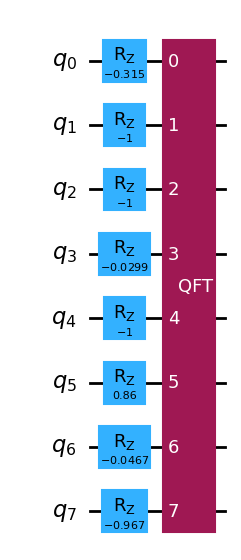

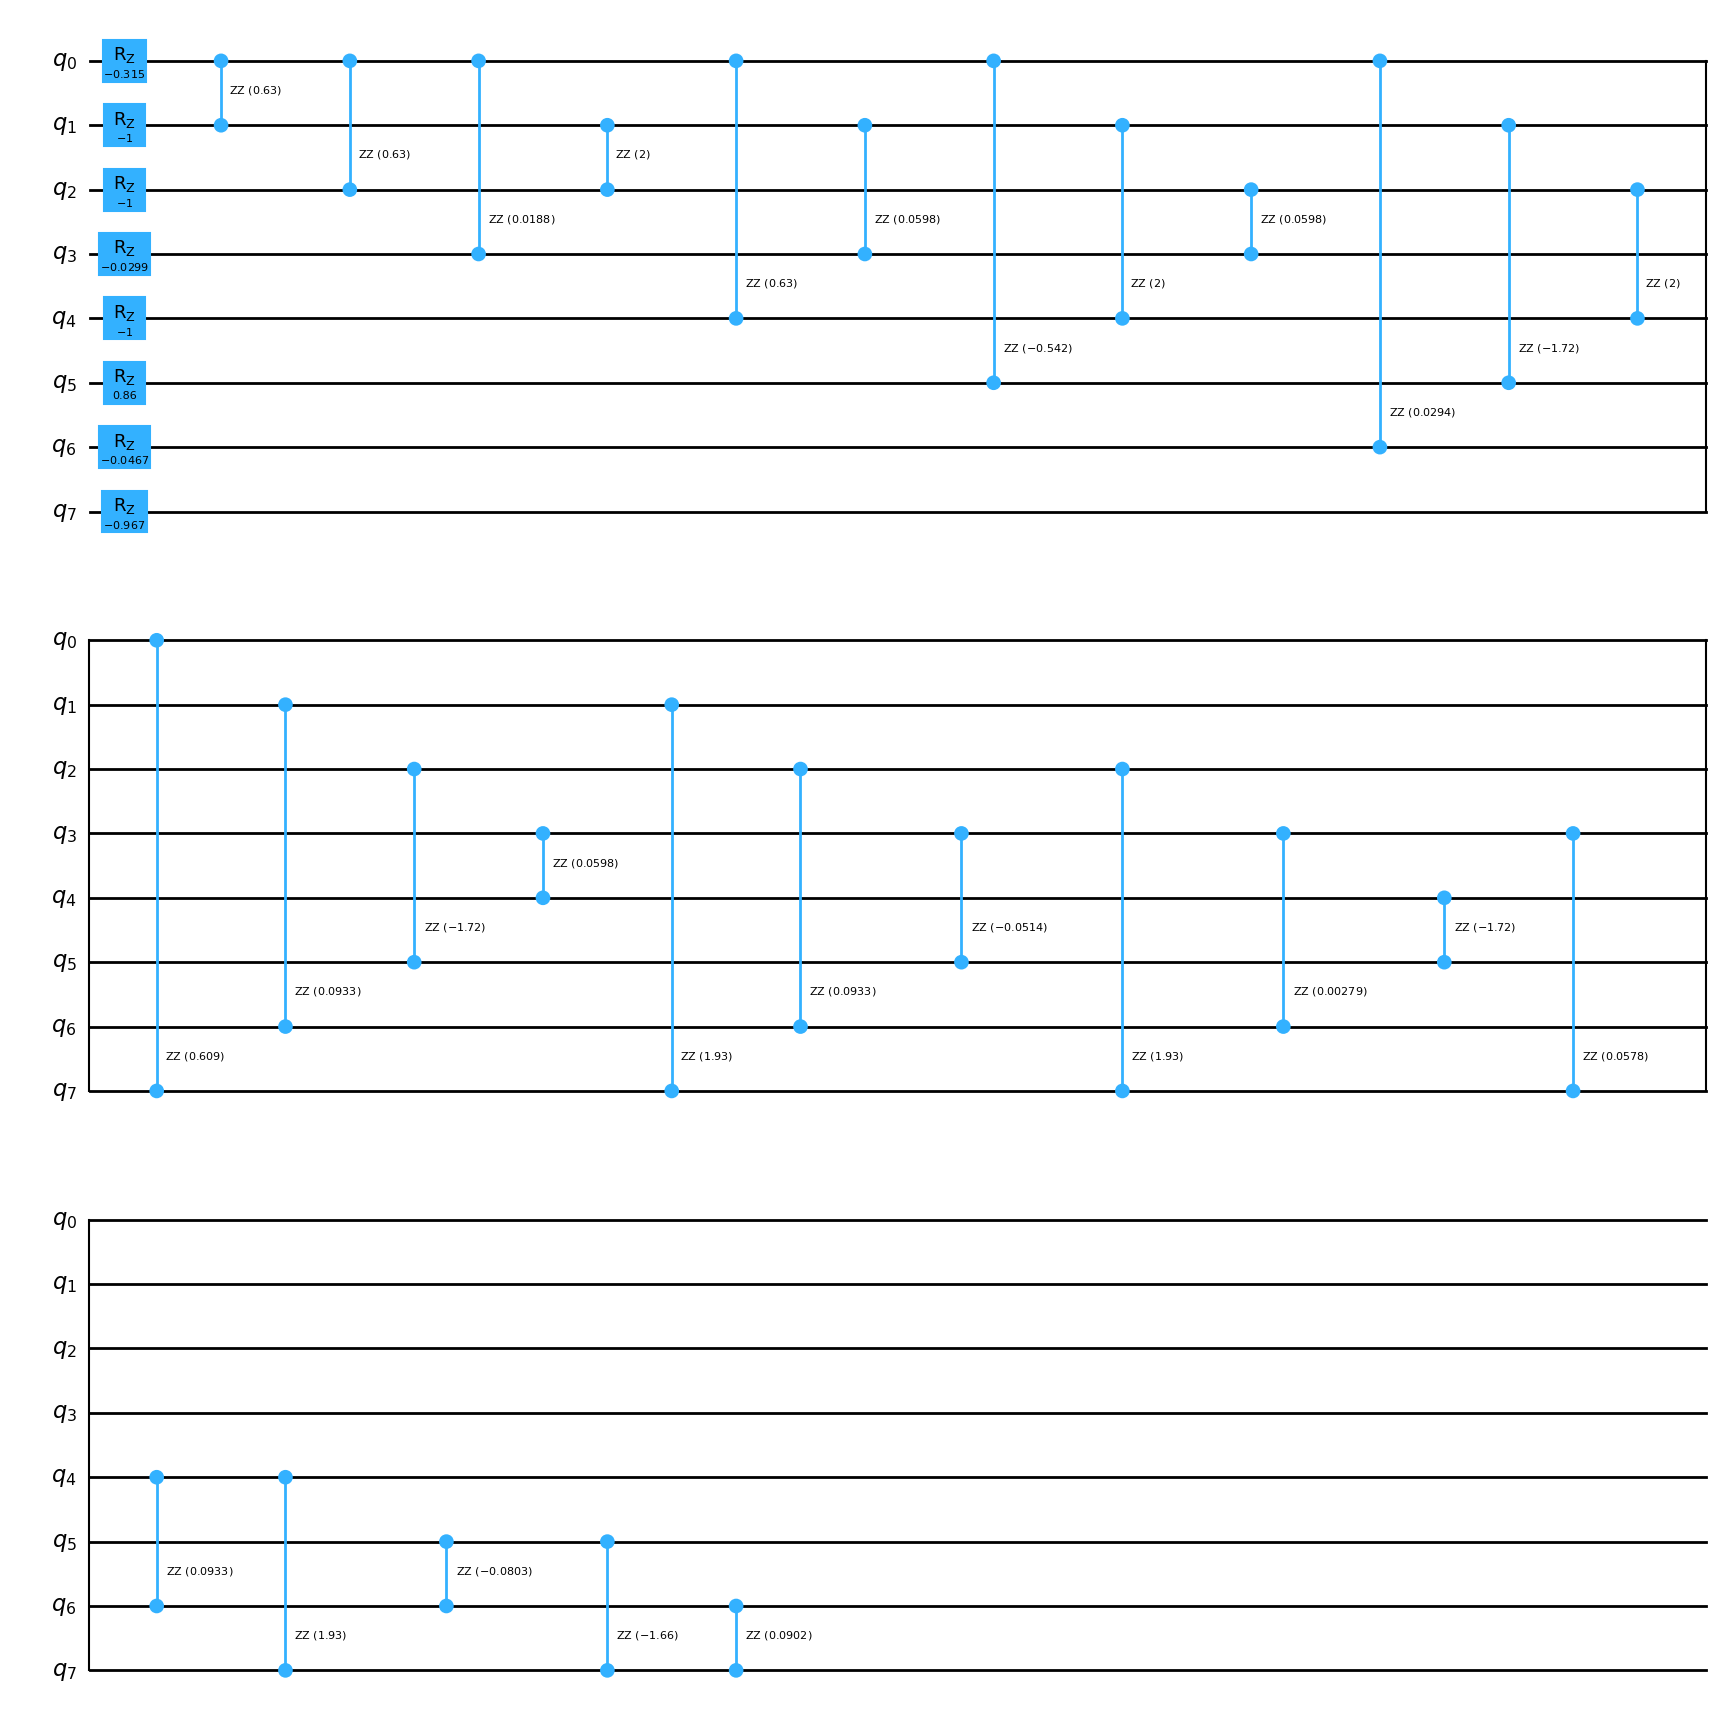

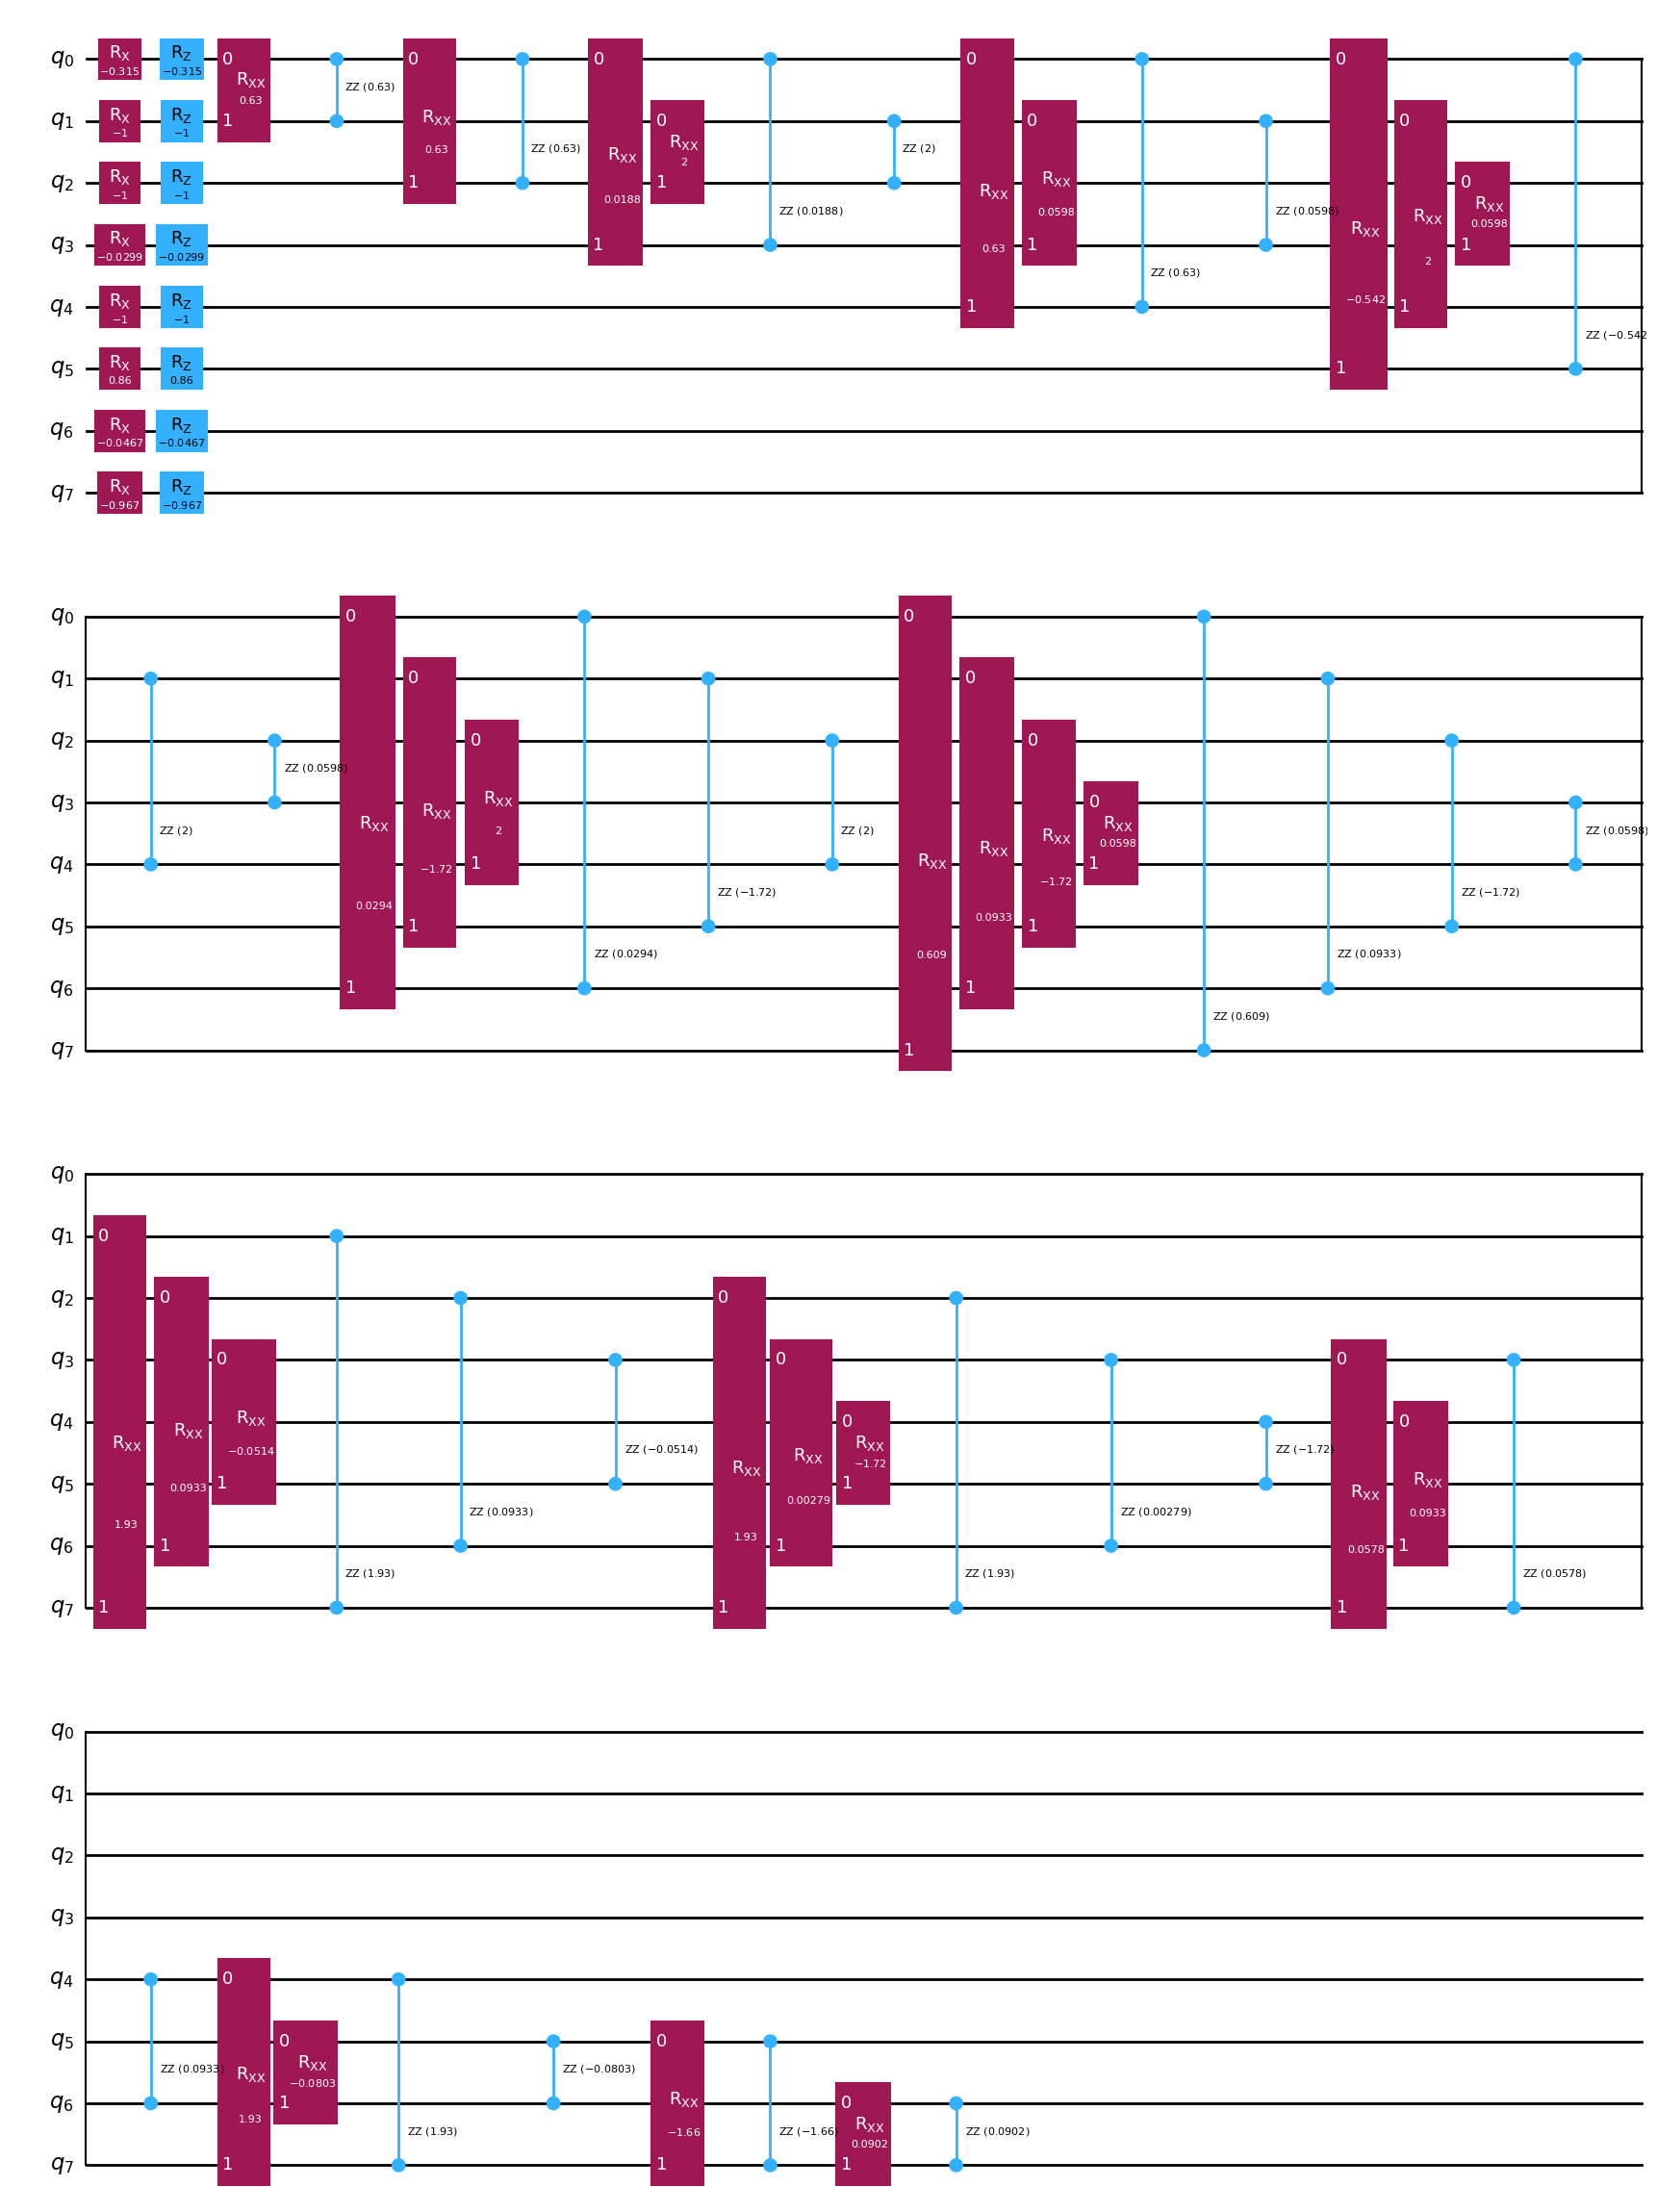

=== Benchmark Feature Maps (Qiskit) ===
            Qubits  Total (s)  ms / muestra  µs / feature
FeatureMap                                               
Fourier          8      4.980         5.092       636.497
Pauli            8      4.883         4.993       624.112
ZZ               8      2.589         2.648       330.955


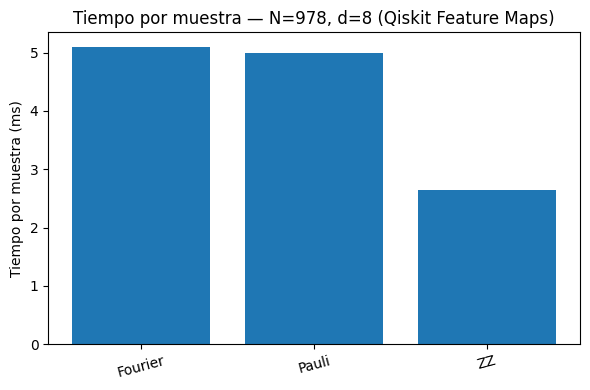

C:\Users\Admin\AppData\Local\Temp\ipykernel_19332\1286803846.py:75: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.compose(QFT(d, do_swaps=True), inplace=True)


[Fourier/QK] Estado global: tamaño = 256 | norma^2 = 0.9999999999999987
[ZZ/QK] Estado global: tamaño = 256 | norma^2 = 1.0000000000000004
[Pauli/QK] Estado global: tamaño = 256 | norma^2 = 1.0


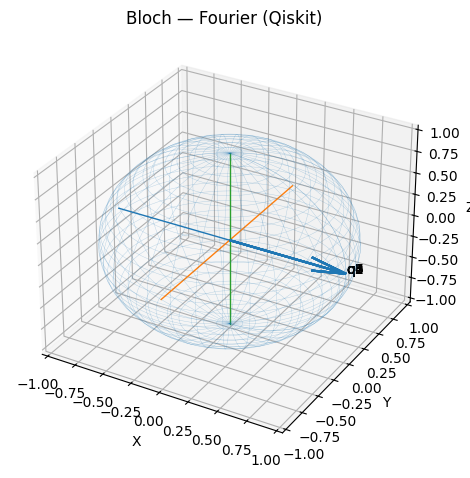

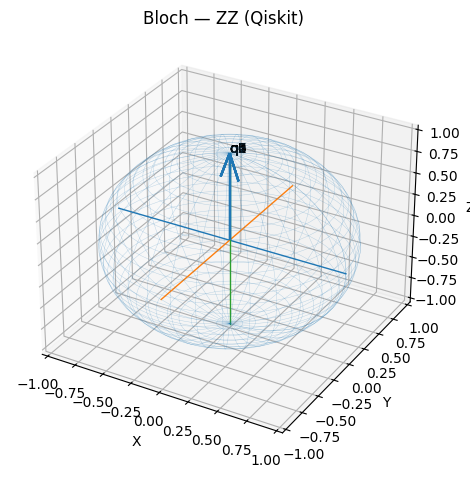

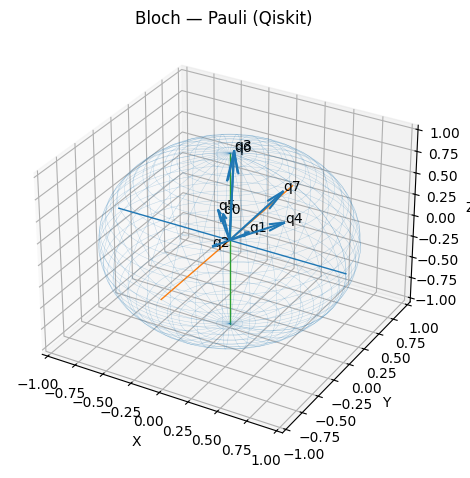

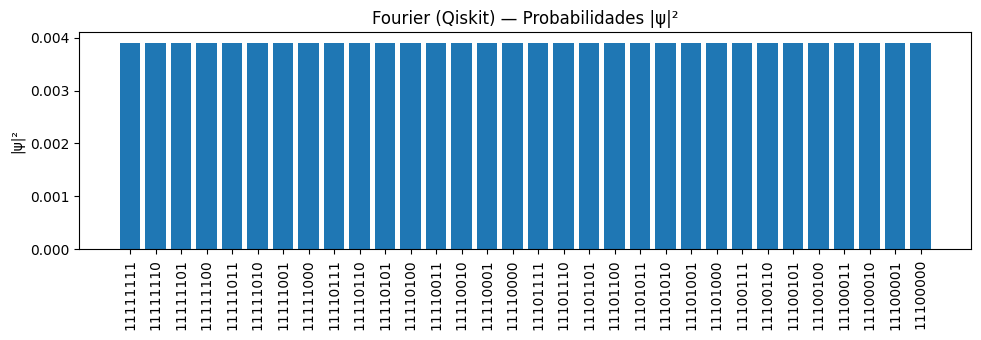

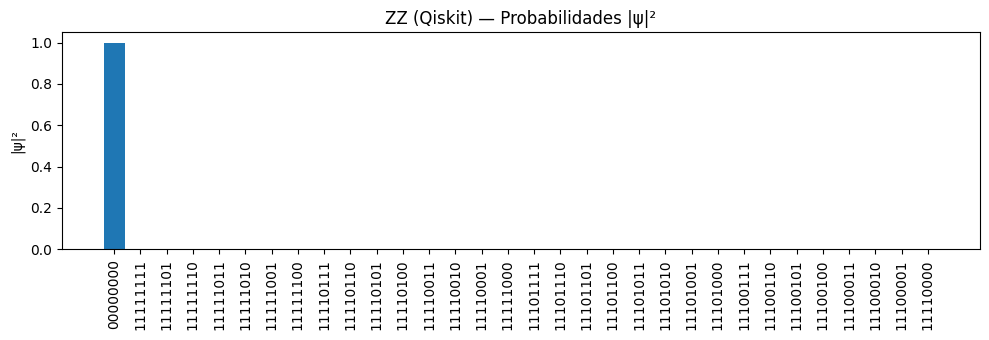

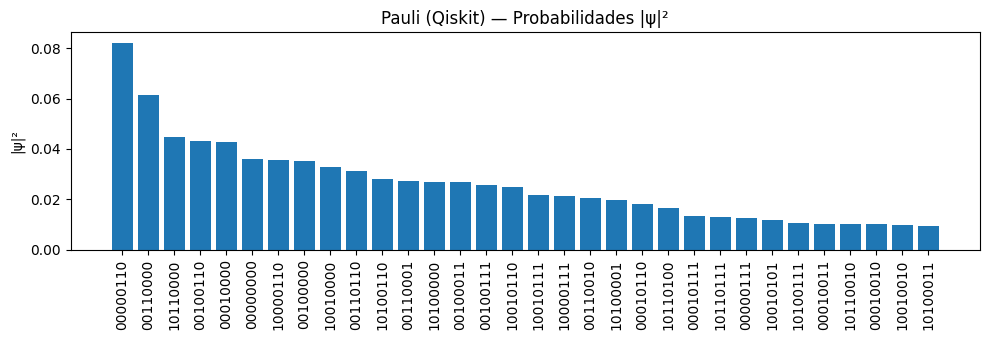

In [20]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace
from qiskit.quantum_info.operators import Pauli
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import QFT, RZZGate, RXXGate

assert 'X' in globals()
N, d = X.shape

def probs_from_statevector(sv):
    p = np.abs(sv.data)**2
    s = p.sum()
    return p if s == 0 else p/s

PAULI_X = Pauli('X').to_matrix()
PAULI_Y = Pauli('Y').to_matrix()
PAULI_Z = Pauli('Z').to_matrix()

def bloch_from_dm(dm_1q: DensityMatrix):
    rho = dm_1q.data
    rx = np.real(np.trace(rho @ PAULI_X))
    ry = np.real(np.trace(rho @ PAULI_Y))
    rz = np.real(np.trace(rho @ PAULI_Z))
    return np.array([rx, ry, rz])

def plot_bloch_vectors(vectors, title="Bloch (Qiskit)"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2*np.pi, 64)
    v = np.linspace(0, np.pi, 32)
    xs = np.outer(np.cos(u), np.sin(v))
    ys = np.outer(np.sin(u), np.sin(v))
    zs = np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, linewidth=0.3, alpha=0.3)
    lim = 1.05
    ax.plot([-1,1],[0,0],[0,0], linewidth=1)
    ax.plot([0,0],[-1,1],[0,0], linewidth=1)
    ax.plot([0,0],[0,0],[-1,1], linewidth=1)
    for i, r in enumerate(vectors):
        ax.quiver(0,0,0, r[0], r[1], r[2], length=1, normalize=False)
        ax.text(r[0], r[1], r[2], f"q{i}")
    ax.set_xlim([-lim, lim]); ax.set_ylim([-lim, lim]); ax.set_zlim([-lim, lim])
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

def _bitstring(i: int, n_qubits: int, little_endian=False) -> str:
    s = format(i, f"0{n_qubits}b")
    return s[::-1] if little_endian else s

def _plot_spectrum(values, n_qubits, title, ylabel, top_k=None, little_endian=False):
    vals = np.asarray(values)
    if top_k is not None and top_k < len(vals):
        idx = np.argsort(vals)[-top_k:][::-1]
    else:
        idx = np.arange(len(vals))
    labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]
    plt.figure(figsize=(10, 3.5))
    plt.bar(np.arange(len(idx)), vals[idx])
    plt.xticks(np.arange(len(idx)), labels, rotation=90)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def qc_fourier_map(x):
    qc = QuantumCircuit(d)
    for i, xi in enumerate(x):
        qc.rz(float(xi), i)
    qc.compose(QFT(d, do_swaps=True), inplace=True)
    return qc

def qc_zz_feature_map(x):
    qc = QuantumCircuit(d)
    for i, xi in enumerate(x):
        qc.rz(float(xi), i)
    for i in range(d):
        for j in range(i+1, d):
            qc.append(RZZGate(2.0*float(x[i%len(x)])*float(x[j%len(x)])), [i, j])
    return qc

def qc_pauli_feature_map(x):
    qc = QuantumCircuit(d)
    for i, xi in enumerate(x):
        qc.rx(float(xi), i)
        qc.rz(float(xi), i)
    for i in range(d):
        for j in range(i+1, d):
            qc.append(RXXGate(2.0*float(x[i%len(x)])*float(x[j%len(x)])), [i, j])
            qc.append(RZZGate(2.0*float(x[i%len(x)])*float(x[j%len(x)])), [i, j])
    return qc

x0 = X[0]
qc_f = qc_fourier_map(x0)
qc_z = qc_zz_feature_map(x0)
qc_p = qc_pauli_feature_map(x0)
display(circuit_drawer(qc_f, output="mpl"))
display(circuit_drawer(qc_z, output="mpl"))
display(circuit_drawer(qc_p, output="mpl"))

def statevector_of(qc):
    return Statevector.from_instruction(qc)

def dm_reducidas_por_qubit(sv: Statevector, n_qubits: int):
    dms = []
    for i in range(n_qubits):
        traced = partial_trace(sv, [j for j in range(n_qubits) if j != i])
        dms.append(traced)
    return dms

def benchmark_qk(build_fn, n_qubits, keep_examples_idx=(0,1,2)):
    t0 = time.perf_counter()
    examples = []
    for i, x in enumerate(X):
        qc = build_fn(x)
        sv = statevector_of(qc)
        if i in keep_examples_idx:
            p = probs_from_statevector(sv)
            idx = int(np.argmax(p))
            examples.append({"index": i, "argmax_idx": idx, "argmax_prob": float(p[idx]), "dim": len(sv.data)})
    total_s = time.perf_counter() - t0
    return total_s, examples, n_qubits

fourier_total_s, ex_f, qf = benchmark_qk(qc_fourier_map, d)
zz_total_s, ex_z, qz = benchmark_qk(qc_zz_feature_map, d)
pauli_total_s, ex_p, qp = benchmark_qk(qc_pauli_feature_map, d)

rows = []
for name, total_s, nq in [("Fourier", fourier_total_s, qf), ("ZZ", zz_total_s, qz), ("Pauli", pauli_total_s, qp)]:
    per_sample = total_s / N
    per_feature = per_sample / d
    rows.append({"FeatureMap": name, "Qubits": nq, "Total (s)": total_s, "ms / muestra": per_sample*1e3, "µs / feature": per_feature*1e6})
df_qk = pd.DataFrame(rows).set_index("FeatureMap").sort_values("ms / muestra", ascending=False)
print("=== Benchmark Feature Maps (Qiskit) ===")
print(df_qk.round(3))
plt.figure(figsize=(6,4))
plt.bar(df_qk.index.tolist(), df_qk["ms / muestra"].values)
plt.ylabel("Tiempo por muestra (ms)")
plt.title(f"Tiempo por muestra — N={N}, d={d} (Qiskit Feature Maps)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

x0 = X[0]
sv = Statevector.from_instruction(qc_fourier_map(x0))
dms = dm_reducidas_por_qubit(sv, d)
bloch = [bloch_from_dm(dm1) for dm1 in dms]
plot_bloch_vectors(bloch, title="Bloch — Fourier (Qiskit)")
print("[Fourier/QK] Estado global: tamaño =", len(sv.data), "| norma^2 =", float(np.sum(np.abs(sv.data)**2)))

sv = Statevector.from_instruction(qc_zz_feature_map(x0))
dms = dm_reducidas_por_qubit(sv, d)
bloch = [bloch_from_dm(dm1) for dm1 in dms]
plot_bloch_vectors(bloch, title="Bloch — ZZ (Qiskit)")
print("[ZZ/QK] Estado global: tamaño =", len(sv.data), "| norma^2 =", float(np.sum(np.abs(sv.data)**2)))

sv = Statevector.from_instruction(qc_pauli_feature_map(x0))
dms = dm_reducidas_por_qubit(sv, d)
bloch = [bloch_from_dm(dm1) for dm1 in dms]
plot_bloch_vectors(bloch, title="Bloch — Pauli (Qiskit)")
print("[Pauli/QK] Estado global: tamaño =", len(sv.data), "| norma^2 =", float(np.sum(np.abs(sv.data)**2)))

def plot_state_amplitudes_qk(sv, n_qubits, title, show_phase=False, top_k=None, little_endian=False):
    data = sv.data
    amp = np.abs(data)
    probs = amp**2
    if top_k is not None and top_k < len(amp):
        idx = np.argsort(amp)[-top_k:][::-1]
    else:
        idx = np.arange(len(amp))
    _plot_spectrum(probs, n_qubits, title + " — Probabilidades |ψ|²", ylabel="|ψ|²", top_k=top_k, little_endian=little_endian)
    if show_phase:
        phase = np.angle(data)
        if top_k is not None and top_k < len(amp):
            idx = np.argsort(amp)[-top_k:][::-1]
        else:
            idx = np.arange(len(amp))
        labels = [_bitstring(i, n_qubits, little_endian=little_endian) for i in idx]
        plt.figure(figsize=(10, 3.0))
        plt.stem(np.arange(len(idx)), phase[idx], use_line_collection=True)
        plt.xticks(np.arange(len(idx)), labels, rotation=90)
        plt.ylabel("fase(ψ) [rad]")
        plt.title(title + " — Fase(ψ)")
        plt.tight_layout()
        plt.show()

x0 = X[0]
sv = Statevector.from_instruction(qc_fourier_map(x0))
plot_state_amplitudes_qk(sv, d, "Fourier (Qiskit)", show_phase=False, top_k=32, little_endian=False)
sv = Statevector.from_instruction(qc_zz_feature_map(x0))
plot_state_amplitudes_qk(sv, d, "ZZ (Qiskit)", show_phase=False, top_k=32, little_endian=False)
sv = Statevector.from_instruction(qc_pauli_feature_map(x0))
plot_state_amplitudes_qk(sv, d, "Pauli (Qiskit)", show_phase=False, top_k=32, little_endian=False)